In [1]:
#!pip3 install ann_visualizer

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import pydicom
import os
import cv2
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.signal import argrelextrema
from scipy import ndimage
from glob import glob
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage import filters
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, median
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import clear_border
from scipy.stats import describe
import sys
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
import tensorflow.keras.models as Models
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
#from ann_visualizer.visualize import ann_viz

'ID00011637202177653955184' error :**The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. GDCM)** 
and this patient ID have window width and window Center are in range, pixeldata works

In [3]:
RUN=3
BATCH_SIZE=252
Drop_1 =0.47484
Drop_2 =0.273813
FOLDS =6
Factor=0.167672
lambda_=0.728884
LR =0.00339344
patience=37
Quantile_1= 0.101379
Quantile_3=0.886283
#date 10/3/2020
BATCH_SIZE=252
Drop_1=0.595458
Drop_2=0.200271
FOLDS=6
Factor=0.354209
_lambda=0.748637
lr=0.00620555
patience=99
#mean_OOF_val_score=7.72143
Drop_3= 0.463196
Quantile_1 =0.275231
Quantile_3=0.826674

In [4]:
def seed_everything(seed): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(42)

In [5]:
train=pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv')
test=pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv')
#sub=pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

In [6]:
#create sub 
patient=test.Patient.values
weeks=np.arange(-12,134)
Patient_week=[]
for p in patient:
    temp=[p+'_'+str(w) for w in weeks]
    Patient_week.append(temp)
Patient_week=np.hstack(Patient_week)
sub=pd.DataFrame(Patient_week,columns=['Patient_Week'])
sub['FVC']=2000
sub['Confidence']=100
sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00419637202311204720264_-11,2000,100
2,ID00419637202311204720264_-10,2000,100
3,ID00419637202311204720264_-9,2000,100
4,ID00419637202311204720264_-8,2000,100
...,...,...,...
725,ID00426637202313170790466_129,2000,100
726,ID00426637202313170790466_130,2000,100
727,ID00426637202313170790466_131,2000,100
728,ID00426637202313170790466_132,2000,100


In [7]:
#test_mask
#top 50 different ct image ct scan
Mask_Image_test=[] # ID,file_name,Masked_Image
Patient_ID=test.Patient.unique()
#Segmented_Image=[] ## ID,file_name,Segmented_Image

for ID in tqdm(Patient_ID):#DP_ID:
    path='/kaggle/input/osic-pulmonary-fibrosis-progression/test/'+ID
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    slices=np.array(slices)
    loc=[s.InstanceNumber for s in slices]
    slices=slices[np.argsort(loc)]
    filename=[s for s in os.listdir(path)]
    pixel_array=[]
    for s in slices:
        try:
            pixel_array.append(s.pixel_array)
        except:
            pass;
    if(len(pixel_array)==0):
        continue;
    ################################################
    if(slices.shape[0]>50):
        change=[]
        for i in range(len(pixel_array)-1):
            curr=pixel_array[i]
            nxt=pixel_array[i+1]
            tmp=np.abs(np.subtract(curr,nxt))
            curr=np.abs(curr)+1
            tmp=np.divide(tmp,curr)
            tmp=np.sum(tmp)
            change.append([i,tmp])
        change=np.array(change)
        change[:,1]=change[:,1]/(nxt.shape[0]*nxt.shape[1])
        pixel_array=np.array(pixel_array)
        ind_=sorted(np.argsort(np.gradient(change[:,1]*100))[::-1][0:50])#
        pixel_array=pixel_array[ind_]
        slices=slices[ind_]
        del ind_,change,curr,nxt,tmp
    else:
        pass;
    #####################################################
    #there are ct images having double padding and common thing in them is they don't have equal number row and col
    if(pixel_array[0].shape[0]!=pixel_array[0].shape[1]):
        tmp=[]
        for p,img in enumerate(pixel_array):
            start=img[0][0]
            ind_x=[]
            ind_y=[]
            for i,r in enumerate(img):
                if(sum(r==start)/img.shape[1]!=1):
                    ind_x.append(i)
            for i,c in enumerate(img.T):
                if(sum(c==start)/img.shape[0]!=1):
                    ind_y.append(i)
            img=img[ind_x[0]:ind_x[-1],ind_y[0]:ind_y[-1]]
            tmp.append(img)
        pixel_array=tmp
    ##########################################################
    winCenter=slices[0].WindowCenter
    winWidth=slices[0].WindowWidth
    try:
        RI=slices[0].RescaleIntercept
    except:
        RI=0;
    try:
        RS=min(slices[0].RescaleSlope,1)
    except:
        RS=1
    #changing the each value of pixel to Hu takes lots resource
    yMin = (winCenter - 0.5 * np.abs(winWidth))
    yMax = (winCenter + 0.5 * np.abs(winWidth))
    yMin = (yMin-RI)/RS
    yMax = (yMax-RI)/RS
    t=np.array(pixel_array).ravel()
    t=t[(t>=yMin)&(t<=yMax)]
    kmeans=KMeans(n_clusters=2, random_state=0).fit(t.reshape((-1,1)))
    ################################################################
    Mask=[]
    for i,p in enumerate(pixel_array):
        pred=kmeans.predict(np.array(p).reshape(-1,1))
        pred=pred.reshape(np.array(p).shape)
        start=pred[0][0]
        pred=np.where(pred==start,1,0)
        #plt.imshow(p)
        #plt.show()
        #plt.imshow(pred)
        #plt.show()
        ################
        binary=pred
        lungs = median(clear_border(binary))
        lungs = morphology.binary_closing(lungs, selem=morphology.disk(7))
        lungs = binary_fill_holes(lungs)
        lungs = morphology.dilation(lungs,np.ones([5,5]))
        #plt.imshow(lungs,cmap='gray')
        #plt.show()
        labels = measure.label(lungs,connectivity=2) # Different labels are displayed in different colorslabel_vals = np.unique(labels)
        #plt.imshow(labels)
        #plt.show()
        labels=np.array(labels)
        lbl_exclude=np.unique([labels[0:60,:],labels[-60:,:]])#there is some ct images that contains table ct scan, so its removed
        label=np.unique(labels)
        #################
        #mean_label=[]
        mask=np.zeros(np.array(p).shape)
        for l in label:
            msk=np.where(labels==l,1,0)
            if(( l in lbl_exclude) | (np.sum(msk)<100)|(np.abs(np.mean(msk*p))<1)):
                continue;
            mask=np.add(mask,np.where(labels==l,1,0))
            #print('label'+' '+str(l)+' ' +str(np.mean(msk*p))+' '+str(np.std(msk*p))+' '+str(np.sum(msk)))
            #mean_label.append([l,np.mean(msk*p)])
        
        mask=mask.astype(np.uint8)
        #print(filename[i])
        #plt.imshow(mask)
        #plt.show()
        inst_num=slices[i].InstanceNumber
        Mask.append([inst_num,mask])
        #Segmented_Image.append([ID,inst_num,mask*p])
    Mask_Image_test.append([ID,Mask])
    del Mask

100%|██████████| 5/5 [06:52<00:00, 82.54s/it]


In [8]:
def splt_array(array):
    r,c=array.shape
    L1=array[0:r//2,0:c//2]
    L2=array[r//2:r,0:c//2]
    R1=array[0:r//2,c//2:c]
    R2=array[r//2:r,c//2:c]
    return [L1,L2,R1,R2]


def stats_inf(mask,data,on='train'):
    ID_stats=[]
    p=[]
    mean_ID=[]
    stastical_inf=[]
    Area=[]
    for m in tqdm(mask):
        ID=m[0]
        inst_num=np.array(m[1])[:,0]
        masked_image=np.array(m[1])[:,1]
        inst_num=inst_num.astype(str)
        inst_num=[i+'.dcm' for i in inst_num]
        data_ID=data[data.Patient==ID]
        temp_=[]
        AREA_=[]
        #################
        for inst,mask_img in zip(inst_num,masked_image):
            path='/kaggle/input/osic-pulmonary-fibrosis-progression/'+on+'/'+ ID+'/'+inst
            Slice=pydicom.read_file(path)
            array=Slice.pixel_array
            if(array.shape[0]!=array.shape[1]):
                #resize the array
                a,b=mask_img.shape
                x=(array.shape[0]-a)//2
                y=(array.shape[1]-b)//2
                array=array[x:x+a,y:y+b]
            AREA_.append(splt_array(mask_img))
            slope=Slice.RescaleSlope
            intercept=Slice.RescaleIntercept
            array=array*slope+intercept
            masked=array*mask_img
            L1,L2,R1,R2=splt_array(masked)
            L1,L2,R1,R2=[spt[(spt<0)] for spt in [L1,L2,R1,R2] ]
            temp=masked[masked<0]#[(masked<-Slice.WindowCenter) &((masked>-1500))])
            if(len(temp)>0):
                temp_.append([L1,L2,R1,R2])
        ###
        prod=np.prod(Slice.PixelSpacing)
        AREA_=np.sum(np.array(AREA_),axis=0)
        AREA_=[np.sum(ar[ar>0])*prod for ar in AREA_]
        ###
        temp_=np.array(temp_)
        temp_=[np.hstack(t) for t in temp_.T]
        #features
        Mode=[stats.mode(t)[0][0] for t in temp_]
        Median=[np.median(t) for t in temp_]
        Mean=[np.mean(t) for t in temp_]
        Skew=[stats.skew(t) for t in temp_]
        Kurt=[stats.kurtosis(t) for t in temp_]
        stastical_inf.append(np.hstack([ID,Mode,Median,Mean,Skew,Kurt,AREA_]))
    return stastical_inf

In [9]:
stats_train=pd.read_csv('../input/stats-df/stats_train.csv')
stastical_inf_test=stats_inf(Mask_Image_test,test,on='test')
columns=columns=['Patient','mode_l1','mode_l2','mode_r1','mode_r2','median_l1','median_l2','median_r1','median_r2','mean_l1','mean_l2','mean_r1','mean_r2','skew_l1','skew_l2','skew_r1','skew_r2','kurt_l1','kurt_l2','kurt_r1','kurt_r2','Area_l1','Area_l2','Area_r1','Area_r2']
stats_test=pd.DataFrame(stastical_inf_test,columns=columns)
stats_test[columns[1:]]=stats_test[columns[1:]].astype(float)
print(stats_test.shape)
stats_test.head()

100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

(5, 25)


,Patient,mode_l1,mode_l2,mode_r1,mode_r2,median_l1,median_l2,median_r1,median_r2,mean_l1,...,skew_r1,skew_r2,kurt_l1,kurt_l2,kurt_r1,kurt_r2,Area_l1,Area_l2,Area_r1,Area_r2
0,ID00419637202311204720264,-1024.0,-1024.0,-1024.0,-1024.0,-809.0,-805.0,-822.0,-822.0,-724.209211,...,1.568695,1.572774,0.738895,0.935054,1.760349,1.851296,86701.990864,175352.734235,87545.149321,185951.767639
1,ID00421637202311550012437,-1024.0,-1024.0,-1024.0,-1024.0,-877.0,-905.0,-884.0,-900.0,-802.346771,...,1.770559,1.994685,2.532547,4.342335,2.641162,3.717110,84149.019840,326743.518112,131481.236833,260354.366631
2,ID00422637202311677017371,-1024.0,-1024.0,-1024.0,-1024.0,-832.0,-769.0,-848.0,-754.0,-747.627864,...,1.375548,0.851563,1.554060,-0.110641,0.865705,-0.279826,141113.068750,137891.721978,83885.104697,127564.450237
3,ID00423637202312137826377,-1024.0,-1024.0,-1024.0,-1024.0,-847.0,-780.0,-897.0,-777.0,-783.448070,...,1.486316,1.033890,1.720072,0.670391,1.388573,0.450381,117384.530163,197150.109386,93278.422165,215555.516815
4,ID00426637202313170790466,-1024.0,-1024.0,-1024.0,-1024.0,-812.0,-815.0,-846.0,-837.0,-716.788919,...,1.673003,1.715121,0.851374,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453


In [10]:
train['STD_FVC']=train.FVC*100/train.Percent
#train['SmokingStatus_label']=train.SmokingStatus.replace({'Ex-smoker':0,'Never smoked':1,'Currently smokes':2})
train['Age_Week']=np.round((train['Age']*12+train['Weeks']/4)/12,decimals=2)
train['Sex_Label']=train.Sex.replace({'Male':79,'Female':21})
train=train.merge(stats_train,on='Patient')
train=pd.concat([train,pd.get_dummies(train['SmokingStatus'])],axis=1)
train


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,STD_FVC,Age_Week,Sex_Label,...,kurt_l2,kurt_r1,kurt_r2,Area_l1,Area_l2,Area_r1,Area_r2,Currently smokes,Ex-smoker,Never smoked
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,3974.0,78.92,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,3974.0,79.10,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,3974.0,79.15,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,3974.0,79.19,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,3974.0,79.23,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,4072.4,73.27,79,...,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453,0,0,1
1536,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,4072.4,73.40,79,...,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453,0,0,1
1537,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,4072.4,73.65,79,...,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453,0,0,1
1538,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,4072.4,73.90,79,...,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453,0,0,1


In [11]:
test['STD_FVC']=test.FVC*100/test.Percent
#test['SmokingStatus_label']=test.SmokingStatus.replace({'Ex-smoker':0,'Never smoked':1,'Currently smokes':2})
test['Age_Week']=np.round((test['Age']*12+test['Weeks']/4)/12,decimals=2)
test['Sex_Label']=test.Sex.replace({'Male':79,'Female':21})
test=pd.merge(test,stats_test,on='Patient',how='left')
test=pd.concat([test,pd.get_dummies(test['SmokingStatus'])],axis=1)
mean_values={ind:value for ind ,value in zip(test.mean().index,test.mean().values)}
test=test.fillna(mean_values)

In [12]:
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,STD_FVC,Age_Week,Sex_Label,...,kurt_l1,kurt_l2,kurt_r1,kurt_r2,Area_l1,Area_l2,Area_r1,Area_r2,Ex-smoker,Never smoked
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,4302.8,73.12,79,...,0.738895,0.935054,1.760349,1.851296,86701.990864,175352.734235,87545.149321,185951.767639,1,0
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,3338.4,68.31,79,...,2.532547,4.342335,2.641162,3.717110,84149.019840,326743.518112,131481.236833,260354.366631,1,0
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,2517.2,73.12,79,...,1.554060,-0.110641,0.865705,-0.279826,141113.068750,137891.721978,83885.104697,127564.450237,1,0
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,4156.0,72.35,79,...,1.720072,0.670391,1.388573,0.450381,117384.530163,197150.109386,93278.422165,215555.516815,1,0
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,4072.4,73.00,79,...,0.851374,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453,0,1


Average Percentage

76.33208812611032


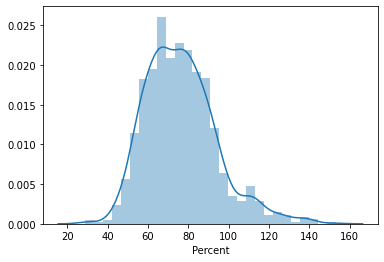

76.8718198781179


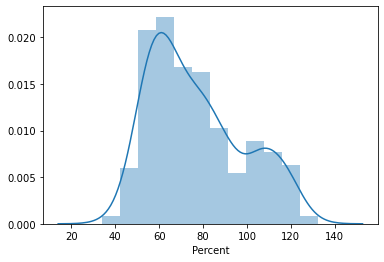

97.59913622735344


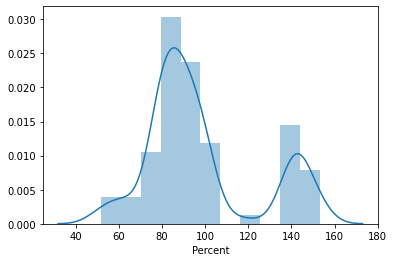

In [13]:
cat=['Ex-smoker','Never smoked','Currently smokes']
for c in cat:
    temp=train[train.SmokingStatus==c].Percent
    print(temp.mean())
    sns.distplot(temp)
    plt.show()

In [14]:
train.corr()

,Weeks,FVC,Percent,Age,STD_FVC,Age_Week,Sex_Label,mode_l1,mode_l2,mode_r1,...,kurt_l2,kurt_r1,kurt_r2,Area_l1,Area_l2,Area_r1,Area_r2,Currently smokes,Ex-smoker,Never smoked
Weeks,1.000000,-0.039128,-0.010885,-0.057984,-0.031956,0.010611,-0.066587,-0.031668,-0.029403,-0.011817,...,-0.011218,0.012872,0.058167,0.013740,0.015101,0.055284,0.054955,0.011764,0.003075,-0.009121
FVC,-0.039128,1.000000,0.671352,-0.097797,0.592034,-0.100649,0.501836,-0.027408,-0.068342,-0.014055,...,0.395302,0.440576,0.438580,0.488862,0.443978,0.474845,0.398585,0.147894,0.158227,-0.240265
Percent,-0.010885,0.671352,1.000000,0.094161,-0.167739,0.093550,-0.123109,-0.001625,-0.012891,0.009198,...,0.516476,0.432597,0.445590,0.305168,0.252968,0.290070,0.205682,0.238648,-0.091660,-0.023250
Age,-0.057984,-0.097797,0.094161,1.000000,-0.231550,0.997646,0.034936,-0.061576,-0.060034,-0.086461,...,0.057989,-0.031499,-0.059671,-0.056709,-0.065716,-0.088224,-0.096793,-0.064321,0.062250,-0.033169
STD_FVC,-0.031956,0.592034,-0.167739,-0.231550,1.000000,-0.234104,0.822586,-0.054760,-0.095306,-0.049460,...,-0.022835,0.106563,0.102189,0.318935,0.315569,0.309543,0.315161,-0.027156,0.301377,-0.302950
Age_Week,0.010611,-0.100649,0.093550,0.997646,-0.234104,1.000000,0.030434,-0.063856,-0.062152,-0.087415,...,0.057302,-0.030668,-0.055782,-0.055862,-0.064786,-0.084566,-0.093172,-0.063609,0.062566,-0.033858
Sex_Label,-0.066587,0.501836,-0.123109,0.034936,0.822586,0.030434,1.000000,-0.003688,-0.040764,-0.010982,...,-0.036015,0.058429,0.068685,0.265936,0.188219,0.226980,0.179850,-0.004925,0.372300,-0.388578
mode_l1,-0.031668,-0.027408,-0.001625,-0.061576,-0.054760,-0.063856,-0.003688,1.000000,0.969018,0.952549,...,-0.023480,-0.108406,-0.000850,-0.105872,-0.115520,-0.067061,-0.119522,0.020873,-0.098396,0.092896
mode_l2,-0.029403,-0.068342,-0.012891,-0.060034,-0.095306,-0.062152,-0.040764,0.969018,1.000000,0.934548,...,-0.052956,-0.114788,-0.008795,-0.155582,-0.149018,-0.084618,-0.143911,0.026522,-0.124285,0.117259
mode_r1,-0.011817,-0.014055,0.009198,-0.086461,-0.049460,-0.087415,-0.010982,0.952549,0.934548,1.000000,...,-0.005207,-0.068938,0.029599,-0.085617,-0.107002,-0.044884,-0.098832,0.043085,-0.123977,0.108640


In [16]:
def Dicom_Data(_path):
    path='/kaggle/input/osic-pulmonary-fibrosis-progression/'+ _path
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(r, file))
    #Dicom Data
    temp=[]
    for f in files:
        Id=f.split('/')[-2]
        file_name=f.split('/')[-1]
        temp.append([[Id,file_name]])
    temp=np.vstack(temp)
    Dicom_Data=pd.DataFrame(temp)
    Dicom_Data.columns=['Patient','Instance_Number']
    Dicom_Data['Instance_Number']=Dicom_Data.Instance_Number.apply(lambda x:x.split('.')[0])
    temp=Dicom_Data.groupby('Patient',as_index=False).agg(No_CT_Images=pd.NamedAgg(column='Instance_Number',aggfunc='count'))
    temp=temp.sort_values('No_CT_Images')
    temp=temp.reset_index(drop=True)
    dicom_metadata=[]
    Dicom_Data=Dicom_Data[Dicom_Data!='ID00011637202177653955184']
    temp=temp[temp.Patient!='ID00011637202177653955184']
    for ID in temp.Patient.values:
        p=path+'/'+ID
        s=os.listdir(p)[0]
        slices=pydicom.dcmread(p+'/'+s)
        dicom_metadata.append([slices.WindowCenter ,slices.WindowWidth,slices.RescaleSlope,slices.RescaleIntercept,slices.Rows,slices.Columns])
    temp[['WindowCenter','WindowWidth','RescaleSlope','RescaleIntercept','Rows','Columns']]=np.array(dicom_metadata).astype(int)
    return Dicom_Data,temp

In [17]:
train_dicom,train_MD=Dicom_Data('train')
test_dicom,test_MD=Dicom_Data('test')

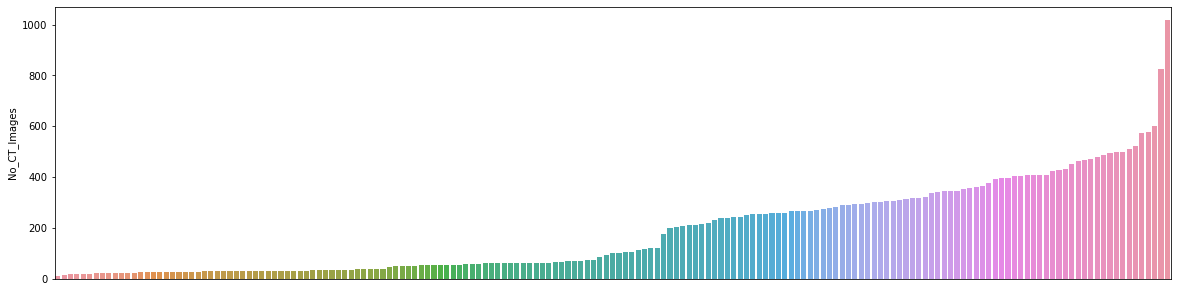

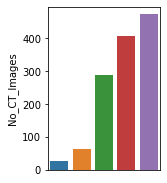

In [18]:
plt.figure(figsize=(20,5))
ax=sns.barplot(x='Patient',y='No_CT_Images',data=train_MD).axes.get_xaxis().set_visible(False)
plt.show()
plt.figure(figsize=(2,3))
ax=sns.barplot(x='Patient',y='No_CT_Images',data=test_MD).axes.get_xaxis().set_visible(False)
plt.show()

Percentage Of Female 21
Percentage Of Male   79


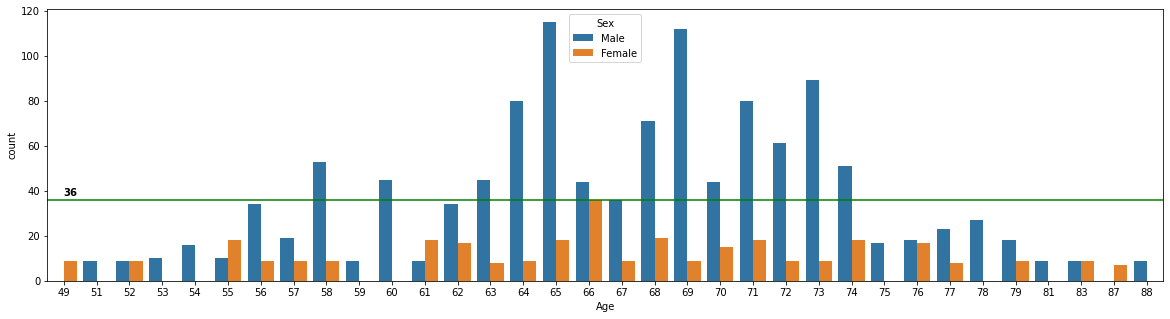

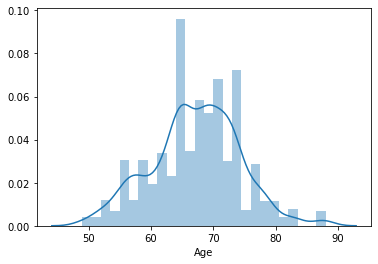

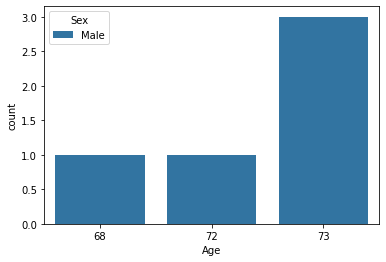

In [19]:
print('Percentage Of Female {}'.format(round(train[train.Sex=='Female'].shape[0]/train.shape[0]*100)))
print('Percentage Of Male   {}'.format(round(train[train.Sex=='Male'].shape[0]/train.shape[0]*100)))
_=plt.figure(figsize=(20,5))
cplot=sns.countplot(x='Age',data=train,hue='Sex')
max_female_agewise=np.max(train[train.Sex=='Female'].groupby(['Age'])['Patient'].count())
cplot.axhline(max_female_agewise,color='g')
cplot.text(0,max_female_agewise+2,str(max_female_agewise),horizontalalignment='left',weight='semibold')
plt.show()
sns.distplot(train.Age)
plt.show()
sns.countplot(x='Age',data=test,hue='Sex')
plt.show()

* There are many ID without BaseWeek information
* The BaseWeek FVC can find by CT images 

The are reason for the duplicate columns 

In [20]:
ID_dup=[]
for ID in train.Patient.unique():
    train_ID=train[train.Patient==ID]
    if(train_ID.shape[0]!=len(train_ID.Weeks.unique())):
        ID_dup.append(ID)
print('There are total Dup',len(ID_dup))

There are total Dup 7


There are 7 ID's having two same weeks data points but different percent/FVC that seems that value weeks are mislabled. 

In [21]:
train[train.Patient=='ID00048637202185016727717']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,STD_FVC,Age_Week,Sex_Label,...,kurt_l2,kurt_r1,kurt_r2,Area_l1,Area_l2,Area_r1,Area_r2,Currently smokes,Ex-smoker,Never smoked
157,ID00048637202185016727717,9,1375,60.059404,70,Female,Never smoked,2289.4,70.19,21,...,-0.565729,-1.025818,-0.716074,33825.9375,60967.125,24777.0,37693.6875,0,0,1
158,ID00048637202185016727717,9,1477,64.514720,70,Female,Never smoked,2289.4,70.19,21,...,-0.565729,-1.025818,-0.716074,33825.9375,60967.125,24777.0,37693.6875,0,0,1
159,ID00048637202185016727717,11,1399,61.107714,70,Female,Never smoked,2289.4,70.23,21,...,-0.565729,-1.025818,-0.716074,33825.9375,60967.125,24777.0,37693.6875,0,0,1
160,ID00048637202185016727717,13,1447,63.204333,70,Female,Never smoked,2289.4,70.27,21,...,-0.565729,-1.025818,-0.716074,33825.9375,60967.125,24777.0,37693.6875,0,0,1
161,ID00048637202185016727717,15,1466,64.034245,70,Female,Never smoked,2289.4,70.31,21,...,-0.565729,-1.025818,-0.716074,33825.9375,60967.125,24777.0,37693.6875,0,0,1
162,ID00048637202185016727717,21,1441,62.942256,70,Female,Never smoked,2289.4,70.44,21,...,-0.565729,-1.025818,-0.716074,33825.9375,60967.125,24777.0,37693.6875,0,0,1
163,ID00048637202185016727717,33,1414,61.762907,70,Female,Never smoked,2289.4,70.69,21,...,-0.565729,-1.025818,-0.716074,33825.9375,60967.125,24777.0,37693.6875,0,0,1
164,ID00048637202185016727717,47,1387,60.583559,70,Female,Never smoked,2289.4,70.98,21,...,-0.565729,-1.025818,-0.716074,33825.9375,60967.125,24777.0,37693.6875,0,0,1
165,ID00048637202185016727717,61,1370,59.841006,70,Female,Never smoked,2289.4,71.27,21,...,-0.565729,-1.025818,-0.716074,33825.9375,60967.125,24777.0,37693.6875,0,0,1


Above data points Weeks 9 appears two time but having different percent/FVC may be  one of 9 is mislabed and it should be 10.

In [22]:
for ID in train.Patient.unique():
    train_ID=train[train.Patient==ID]
    if(train_ID.shape[0]!=len(train_ID.Weeks.unique())):
        weeks=train_ID.Weeks
        a,b=np.unique(weeks,return_counts=True)
        rep_week=a[np.where(b==2)[0]][0]
        temp=train_ID[train_ID.Weeks==rep_week].sort_values(['Percent'],ascending=False).index
        ind=np.setdiff1d(train_ID.index,temp)
        ind=np.append(temp,ind)
        train_ID=train_ID.loc[ind].sort_values(['Weeks'])
        temp=np.nonzero(train_ID.Weeks.values==rep_week)[0]
        ind=temp[np.argmin(np.abs(train_ID.shape[0]//2-temp))]
        ind=[ind-1,ind,ind+1]
        week=train_ID.Weeks.values[ind]
        week[1]=(week[0]+week[2])/2
        Week=train_ID.Weeks.values
        Week[ind[1]]=week[1]
        train_ID['Weeks']=Week
        train[train.Patient==ID]=train_ID

#No difference Range Sex
percentage and FVC

In [23]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,STD_FVC,Age_Week,Sex_Label,...,kurt_l2,kurt_r1,kurt_r2,Area_l1,Area_l2,Area_r1,Area_r2,Currently smokes,Ex-smoker,Never smoked
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,3974.0,78.92,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,3974.0,79.10,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,3974.0,79.15,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,3974.0,79.19,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,3974.0,79.23,79,...,-0.318195,0.190668,-0.307508,105445.999919,124243.087980,101790.927827,81772.929086,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,4072.4,73.27,79,...,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453,0,0,1
1536,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,4072.4,73.40,79,...,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453,0,0,1
1537,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,4072.4,73.65,79,...,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453,0,0,1
1538,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,4072.4,73.90,79,...,1.307223,1.997398,2.364676,133879.361328,300819.672852,167890.858398,300423.439453,0,0,1


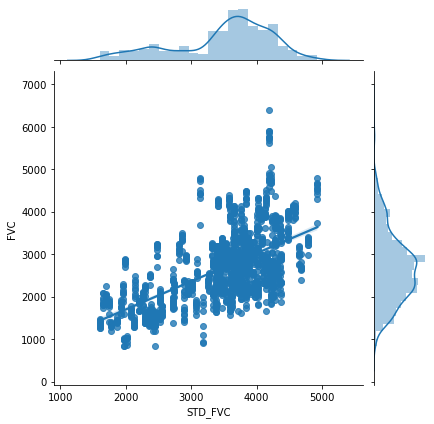

<Figure size 360x360 with 0 Axes>

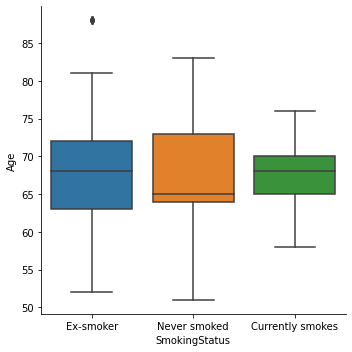

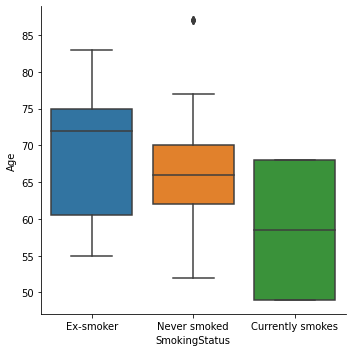

In [24]:
#sns.catplot(x='Sex',y='FVC',data=train,)
sns.jointplot(x='STD_FVC',y='FVC',data=train,kind='reg')
plt.show()
plt.figure(figsize=(5,5))
sns.catplot(x='SmokingStatus',y='Age',data=train[train.Sex=='Male'],kind='box')
plt.show()
sns.catplot(x='SmokingStatus',y='Age',data=train[train.Sex=='Female'],kind='box')
data=train[train.Sex=='Male']

In the Dataset there are more Number Male than Female, percentage wise (Female 21% and Male 79%)

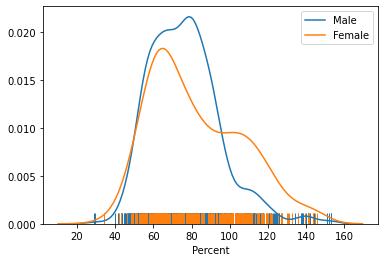

In [25]:
sns.distplot(train[train.Sex=='Male'].Percent,hist=False,rug=True,label='Male')
sns.distplot(train[train.Sex=='Female'].Percent,hist=False,rug=True,label="Female")
plt.show()

Validation Is Done Patient Wise

In [26]:
#train_base
ind=[]
for ID in train.Patient.unique():
    train_ID=train[train.Patient==ID]
    index=train_ID[train_ID.Weeks==np.min(train_ID.Weeks)].index
    ind.append(index)
train_base=train.iloc[np.hstack(ind),:].copy()
#train_base.corr()
train_base['Base_Percent']=train_base.Percent
train_base['Base_FVC']=train_base.FVC
train_base['Base_Weeks']=train_base.Weeks
train_base=train_base.drop(columns=['Percent','FVC','Weeks'])
train=train.merge(train_base[['Patient','Base_Percent','Base_FVC','Base_Weeks']],on='Patient')

In [27]:
#-12 Week to 133 Weeks in the test part
#Validation data
def validation(train):
    Age=[49,70,68,83]
    val_ID=[]
    for age in Age:
        train_age=train[(train.Age==age)]
        ID=train_age.Patient.unique()
        val_ID.append(np.random.choice(ID,1)[0])
    array=train.Patient.unique()
    train_ID=np.setdiff1d(array,val_ID)
    return val_ID,train_ID
val_ID,train_ID=validation(train)
ind=np.array([train[train.Patient==ID].index for ID in val_ID])
valid_data=train.loc[np.hstack(ind),:]

ind=np.array([train_base[train_base.Patient==ID].index for ID in val_ID])
valid_base=train_base.loc[np.hstack(ind),:]

ind=[train[train.Patient==ID].index for ID in train_ID]
train_data=train.loc[np.hstack(ind),:]

ind=np.array([train_base[train_base.Patient==ID].index for ID in train_ID])
train_data_base=train_base.loc[np.hstack(ind),:]

In [28]:
features=np.array(['Weeks','Ex-smoker','Never smoked','Age','STD_FVC','Sex_Label','skew_l1','skew_l2','skew_r1','skew_r2','mean_l1','mean_l2','mean_r1','mean_r2','kurt_l1','kurt_l2','kurt_r1','kurt_r2','Base_Percent','Base_Weeks','Base_FVC','Area_l1','Area_l2','Area_r1','Area_r2'])
target=['FVC']
features_cat=['Ex-smoker','Never smoked']
features_numerical=np.array(['Sex_Label','Weeks','Age','STD_FVC','skew_l1','skew_l2','skew_r1','skew_r2','mean_l1','mean_l2','mean_r1','mean_r2','kurt_l1','kurt_l2','kurt_r1','kurt_r2','Base_Percent','Base_Weeks','Base_FVC','Area_l1','Area_l2','Area_r1','Area_r2'])

In [29]:
sub['Patient']=sub['Patient_Week'].apply(lambda x : x.split('_')[0])
sub['Weeks']=sub['Patient_Week'].apply(lambda x : x.split('_')[1])
sub.drop(columns=["Confidence","FVC"],inplace=True)
test['Base_Percent']=test.Percent
test['Base_FVC']=test.FVC
test['Base_Weeks']=test.Weeks
test=test.drop(columns=['Percent','FVC','Weeks'])
#train=train.merge(train_base[['Patient','Base_Percent','Base_FVC']],on='Patient')
sub=sub.merge(test,on='Patient')
sub.Weeks=sub.Weeks.astype(int)
sub.head()

,Patient_Week,Patient,Weeks,Age,Sex,SmokingStatus,STD_FVC,Age_Week,Sex_Label,mode_l1,...,kurt_r2,Area_l1,Area_l2,Area_r1,Area_r2,Ex-smoker,Never smoked,Base_Percent,Base_FVC,Base_Weeks
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,1.851296,86701.990864,175352.734235,87545.149321,185951.767639,1,0,70.186855,3020,6
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,1.851296,86701.990864,175352.734235,87545.149321,185951.767639,1,0,70.186855,3020,6
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,1.851296,86701.990864,175352.734235,87545.149321,185951.767639,1,0,70.186855,3020,6
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,1.851296,86701.990864,175352.734235,87545.149321,185951.767639,1,0,70.186855,3020,6
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,1.851296,86701.990864,175352.734235,87545.149321,185951.767639,1,0,70.186855,3020,6


In [30]:
array=[train[c].values for c in ['Area_l1','Area_l2','Area_r1','Area_r2']]
array=np.sum(array,axis=0)
train['Area']=array
#train.corr()
array=[sub[c].values for c in ['Area_l1','Area_l2','Area_r1','Area_r2']]
array=np.sum(array,axis=0)
sub['Area']=array

1


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


FOLD1
The average val-loss for epoch 0 is 74.28 and the val-score is 68.20539855957031

Epoch 00181: ReduceLROnPlateau reducing learning rate to 0.003640000009909272.

Epoch 00231: ReduceLROnPlateau reducing learning rate to 0.003956666681915522.
The average val-loss for epoch 250 is 4.46 and the val-score is 3.4073104858398438

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.004273333121091127.

Epoch 00331: ReduceLROnPlateau reducing learning rate to 0.0045900000259280205.

Epoch 00381: ReduceLROnPlateau reducing learning rate to 0.004906666465103626.

Epoch 00431: ReduceLROnPlateau reducing learning rate to 0.005223333369940519.
The average val-loss for epoch 500 is 4.49 and the val-score is 5.0753936767578125

Epoch 00527: ReduceLROnPlateau reducing learning rate to 0.005831333342939615.

Epoch 00577: ReduceLROnPlateau reducing learning rate to 0.006147999782115221.

Epoch 00627: ReduceLROnPlateau reducing learning rate to 0.005252501927316189.

Epoch 00677: ReduceLROnPl

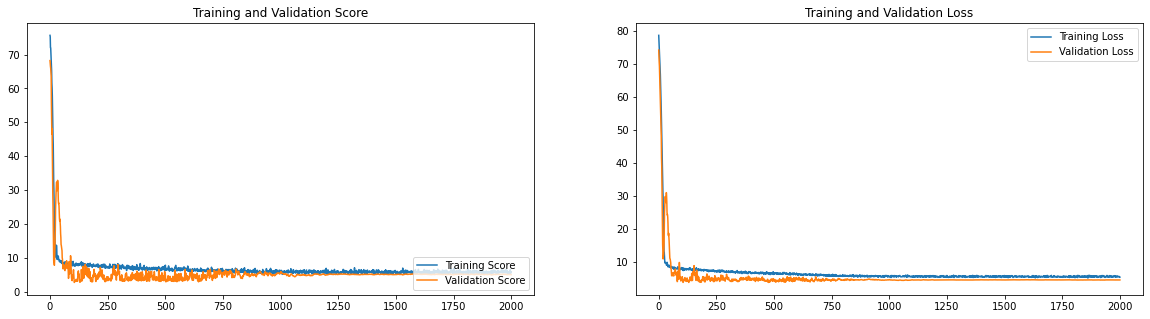

FOLD2
The average val-loss for epoch 0 is 81.51 and the val-score is 76.482421875

Epoch 00154: ReduceLROnPlateau reducing learning rate to 0.003469000104814768.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.0037856667768210173.
The average val-loss for epoch 250 is 6.94 and the val-score is 4.924816131591797

Epoch 00254: ReduceLROnPlateau reducing learning rate to 0.004102333448827267.

Epoch 00304: ReduceLROnPlateau reducing learning rate to 0.0044189998880028725.

Epoch 00354: ReduceLROnPlateau reducing learning rate to 0.0047356667928397655.

Epoch 00404: ReduceLROnPlateau reducing learning rate to 0.005052333232015371.

Epoch 00454: ReduceLROnPlateau reducing learning rate to 0.005369000136852264.
The average val-loss for epoch 500 is 6.64 and the val-score is 5.220729351043701

Epoch 00504: ReduceLROnPlateau reducing learning rate to 0.00568566657602787.

Epoch 00554: ReduceLROnPlateau reducing learning rate to 0.006002333480864763.

Epoch 00604: ReduceLROnPlateau 

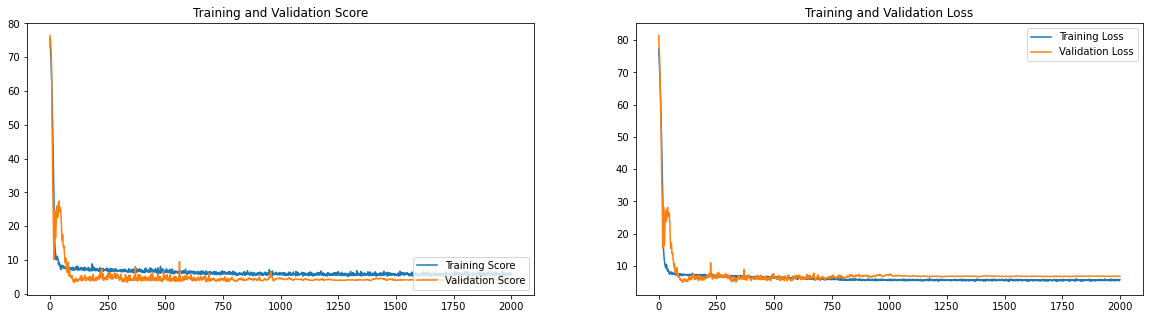

FOLD3
The average val-loss for epoch 0 is 74.48 and the val-score is 81.01057434082031

Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.0029306665528565645.

Epoch 00192: ReduceLROnPlateau reducing learning rate to 0.0037096666637808084.

Epoch 00242: ReduceLROnPlateau reducing learning rate to 0.004026333335787058.
The average val-loss for epoch 250 is 5.20 and the val-score is 3.3800292015075684

Epoch 00292: ReduceLROnPlateau reducing learning rate to 0.004342999774962664.

Epoch 00342: ReduceLROnPlateau reducing learning rate to 0.004659666679799557.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 0.0049763331189751625.

Epoch 00442: ReduceLROnPlateau reducing learning rate to 0.005293000023812056.

Epoch 00492: ReduceLROnPlateau reducing learning rate to 0.005609666462987661.
The average val-loss for epoch 500 is 5.47 and the val-score is 5.489479064941406

Epoch 00542: ReduceLROnPlateau reducing learning rate to 0.0059263333678245544.

Epoch 00592: ReduceLROn

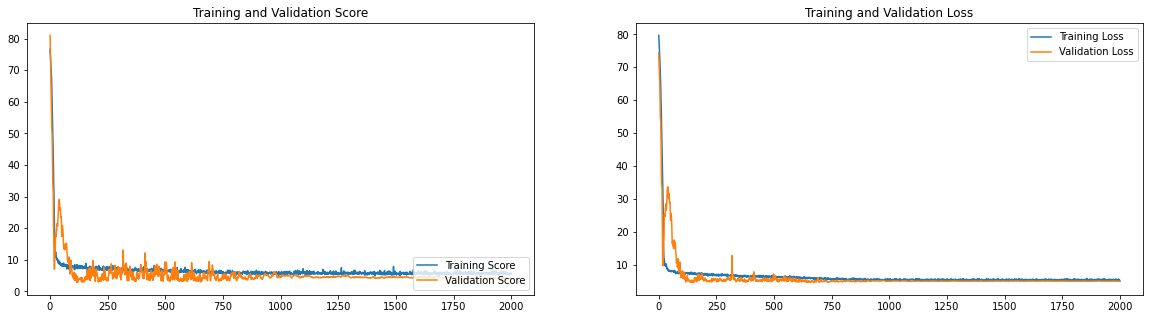

FOLD4
The average val-loss for epoch 0 is 75.16 and the val-score is 74.1654052734375

Epoch 00070: ReduceLROnPlateau reducing learning rate to 0.002937000012025237.

Epoch 00222: ReduceLROnPlateau reducing learning rate to 0.003899666713550687.
The average val-loss for epoch 250 is 5.45 and the val-score is 4.958033561706543

Epoch 00272: ReduceLROnPlateau reducing learning rate to 0.004216333385556936.

Epoch 00322: ReduceLROnPlateau reducing learning rate to 0.004532999824732542.

Epoch 00372: ReduceLROnPlateau reducing learning rate to 0.004849666729569435.

Epoch 00422: ReduceLROnPlateau reducing learning rate to 0.005166333168745041.

Epoch 00472: ReduceLROnPlateau reducing learning rate to 0.005483000073581934.
The average val-loss for epoch 500 is 5.62 and the val-score is 4.5924835205078125

Epoch 00522: ReduceLROnPlateau reducing learning rate to 0.00579966651275754.

Epoch 00572: ReduceLROnPlateau reducing learning rate to 0.006116333417594433.

Epoch 00622: ReduceLROnPlatea

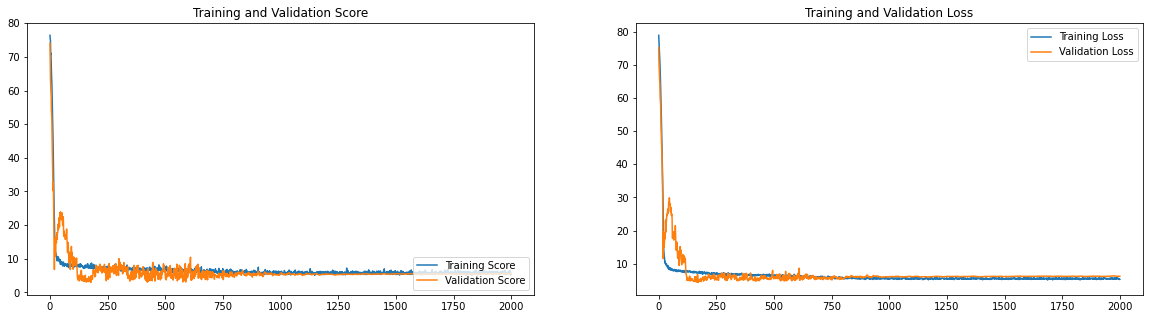

FOLD5
The average val-loss for epoch 0 is 73.03 and the val-score is 68.60986328125

Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.0029243333265185356.

Epoch 00240: ReduceLROnPlateau reducing learning rate to 0.004013666883111.
The average val-loss for epoch 250 is 5.67 and the val-score is 5.253296375274658

Epoch 00292: ReduceLROnPlateau reducing learning rate to 0.004342999774962664.

Epoch 00342: ReduceLROnPlateau reducing learning rate to 0.004659666679799557.

Epoch 00395: ReduceLROnPlateau reducing learning rate to 0.00499533349648118.

Epoch 00445: ReduceLROnPlateau reducing learning rate to 0.005311999935656786.

Epoch 00495: ReduceLROnPlateau reducing learning rate to 0.005628666840493679.
The average val-loss for epoch 500 is 6.52 and the val-score is 7.55120849609375

Epoch 00545: ReduceLROnPlateau reducing learning rate to 0.005945333279669285.

Epoch 00595: ReduceLROnPlateau reducing learning rate to 0.006262000184506178.

Epoch 00645: ReduceLROnPlateau redu

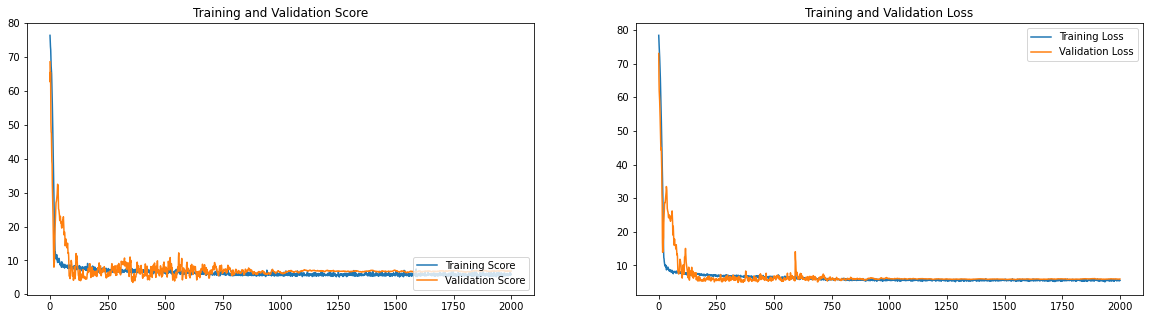

FOLD6
The average val-loss for epoch 0 is 80.10 and the val-score is 79.26640319824219

Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.0035006667021661997.

Epoch 00209: ReduceLROnPlateau reducing learning rate to 0.003817333374172449.
The average val-loss for epoch 250 is 8.97 and the val-score is 7.5980634689331055

Epoch 00259: ReduceLROnPlateau reducing learning rate to 0.004133999813348055.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 0.004450666718184948.

Epoch 00359: ReduceLROnPlateau reducing learning rate to 0.004767333157360554.

Epoch 00409: ReduceLROnPlateau reducing learning rate to 0.005084000062197447.

Epoch 00459: ReduceLROnPlateau reducing learning rate to 0.005400666501373053.
The average val-loss for epoch 500 is 8.44 and the val-score is 5.685445308685303

Epoch 00509: ReduceLROnPlateau reducing learning rate to 0.005717333406209946.

Epoch 00559: ReduceLROnPlateau reducing learning rate to 0.0060339998453855515.

Epoch 00609: ReduceLROnPl

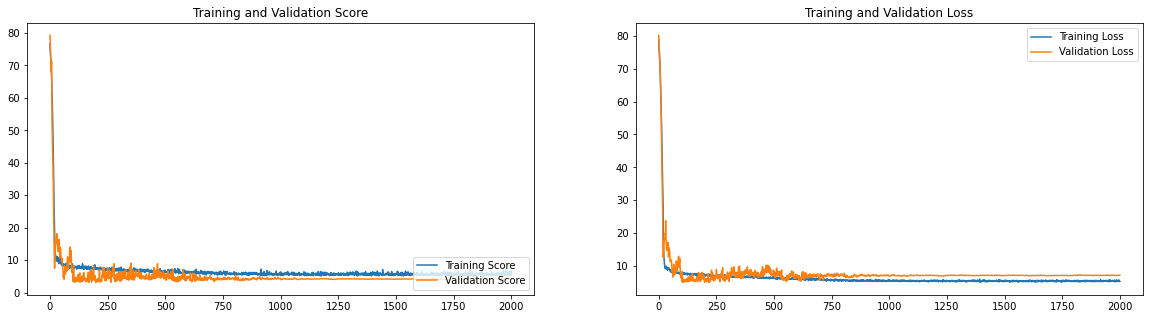

3.8043624560038247
Abs_error 155.27216359118427
Exp_error 145.22928930503582
pred_error 148.11402474223502
train


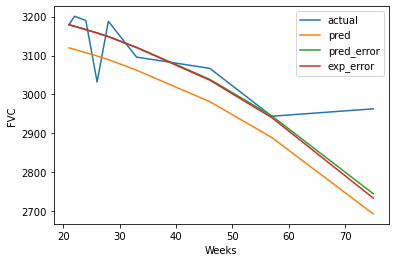

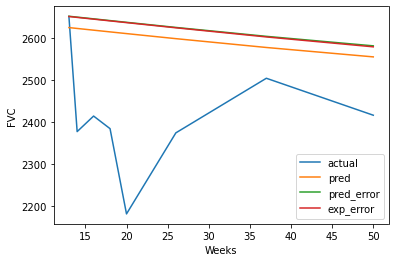

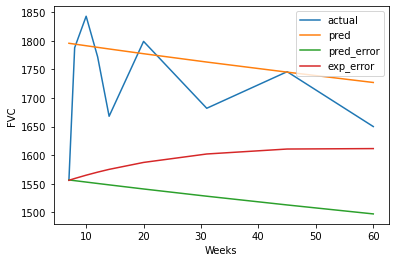

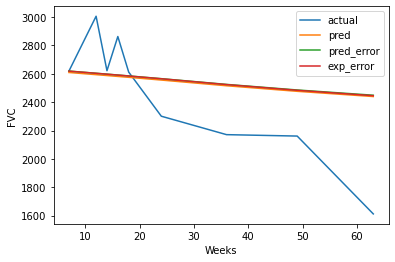

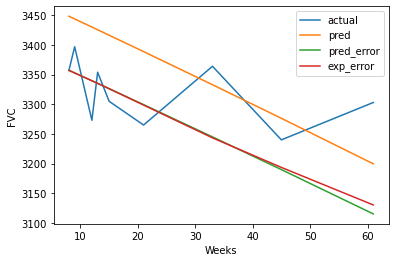

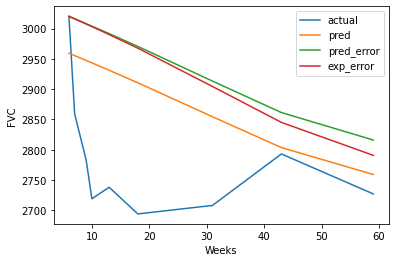

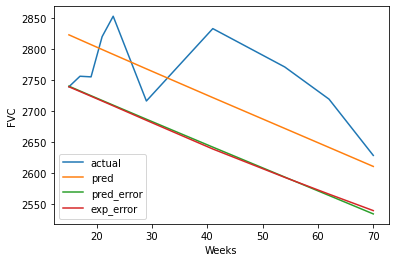

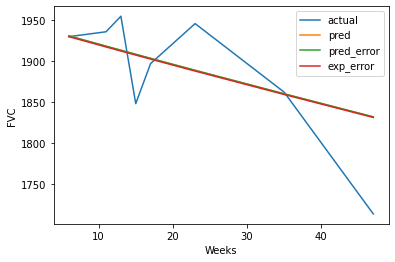

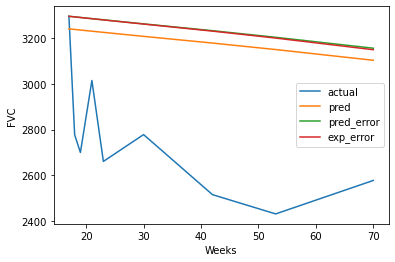

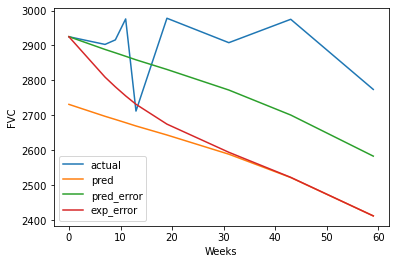

test


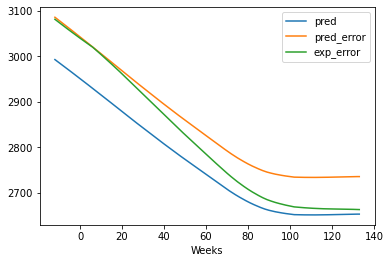

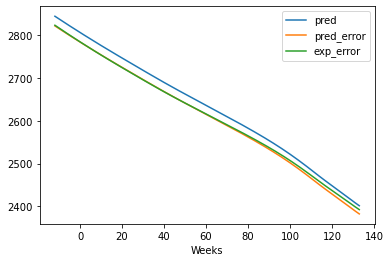

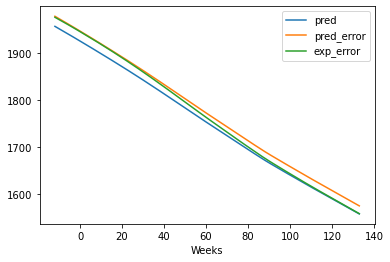

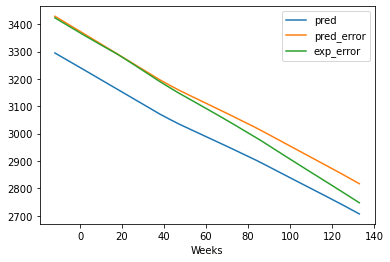

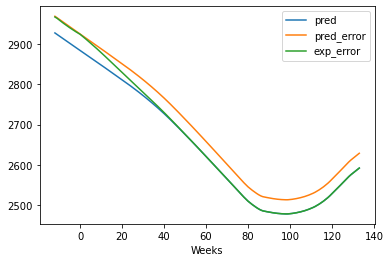

In [31]:
#neural

features=np.array(['Weeks','Ex-smoker','Never smoked','Age','STD_FVC','Sex_Label','skew_l1','skew_l2','skew_r1','skew_r2','mean_l1','mean_l2','mean_r1','mean_r2','kurt_l1','kurt_l2','kurt_r1','kurt_r2','Base_Percent','Base_Weeks','Base_FVC','Area_l1','Area_l2','Area_r1','Area_r2','Area'])
#target=['FVC']
target=['Percent']
features_cat=['Ex-smoker','Never smoked']
features_numerical=np.array(['Sex_Label','Weeks','Age','STD_FVC','skew_l1','skew_l2','skew_r1','skew_r2','mean_l1','mean_l2','mean_r1','mean_r2','kurt_l1','kurt_l2','kurt_r1','kurt_r2','Base_Percent','Base_Weeks','Base_FVC','Area_l1','Area_l2','Area_r1','Area_r2','Area'])

#params
if(test.shape[0]>5):
    RUN=3
else:
    RUN=1
print(RUN)
EPOCHS = 2000
BATCH_SIZE=252
Drop_1=0.395458
Drop_2=0.200271
Drop_3= 0.2#463196
FOLDS=6
Factor=0.25#54209
_lambda=0.748637
lr=0.00320555
patience=50#patience=99
#mean_OOF_val_score=7.72143
Quantile_1 =0.275231
Quantile_3=0.826674
######################################
temp_1=train.copy()
temp_2=sub.copy()
data=pd.concat([temp_1,temp_2],axis=0)
temp_1[features_numerical]=(temp_1[features_numerical]-data[features_numerical].mean())/data[features_numerical].std()
temp_2[features_numerical]=(temp_2[features_numerical]-data[features_numerical].mean())/data[features_numerical].std()
X_train=temp_1[features].values#((temp-temp.mean())/temp.std()).values
y_train=temp_1[target].values
X_test = temp_2[features].values
train_preds_nn = np.zeros((X_train.shape[0],1))
test_preds_nn = np.zeros((X_test.shape[0],1))
y_train=y_train.astype(np.float64)
#########################################################
def pediction_error(data,pred):
    predict_error=[]
    error_ID=[]
    b_exp_=[]
    for ID in data.Patient.unique():
        temp=data[data.Patient==ID].copy()
        predict=pred[temp.index]
        #predict=predict*(temp['STD_FVC'].values)/100
        temp['FVC_pred']=predict
        base_week,base_fvc,fvc_pred=temp.loc[temp.Weeks==temp.Base_Weeks.values[0]][['Base_Weeks','Base_FVC','FVC_pred']].values[0]
        if(fvc_pred!=0):
            error=int(base_fvc)/int(fvc_pred)
            predict=predict*error
        else:
            error=base_fvc-fvc_pred
            predict=predict+error
            print('zero__')
        
        error_exp=base_fvc-fvc_pred
        Weeks=temp.Weeks.values
        b=pred[data.Patient==ID]
        exp=np.exp(-np.abs(base_week-Weeks)/(np.abs(base_week)+1)*(np.abs(base_fvc-b)/base_fvc))
        exp_error=exp*error_exp
        b_exp=b+exp_error #pred_error[train.Patient==ID]
        
        b_exp_.append(b_exp)
        predict_error.append(predict)
        error_ID.append([ID,error])
    b_exp_=np.hstack(b_exp_)
    predict_error=np.hstack(predict_error)
    return predict_error,b_exp_,error_ID


def plot_history(history):
    #score = history.history['metric']
    #val_score = history.history['val_metric']
    score = history.history['abs_error']
    val_score = history.history['val_abs_error']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    # create subplots
    plt.figure(figsize = (20,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, score, label = 'Training Score')
    plt.plot(epochs_range, val_score, label = 'Validation Score')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Score')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    # limit y-values for beter zoom-scale
    #plt.ylim(0.3 * np.mean(val_loss), 1.8 * np.mean(val_loss))

    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    plt.show()




#Learning Rate Sechduler
def get_lr_callback(batch_size=64,plot=False):
    LR_START=0.01
    LR_MAX= 0.0001*batch_size
    LR_MIN=0.0001
    ######
    LR_RAMP_EP=EPOCHS*0.3
    LR_SUS_EP  = 0
    LR_DECAY   = 0.993

    def lr_scheduler(epoch):
        if(epoch<LR_RAMP_EP):
            lr=(LR_MAX-LR_START)/LR_RAMP_EP*epoch+LR_START
        elif(epoch<LR_RAMP_EP+LR_SUS_EP):
            lr=LR_MAX
        else:
            lr=(LR_MAX-LR_MIN)*LR_DECAY**(epoch-LR_RAMP_EP-LR_SUS_EP)+LR_MIN
        return lr
    if(plot==False):
        lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_scheduler,verbose=False)
        return lr_callback
    else:
        return lr_scheduler

#custom callbacks
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_score=[]
        
    def on_epoch_end(self, epoch, logs=None):
        self.val_score.append(logs['val_abs_error'])
        if epoch % 250 == 0 or epoch == (EPOCHS -1 ):
            print(f"The average val-loss for epoch {epoch} is {logs['val_loss']:.2f}"
                  f" and the val-score is {logs['val_abs_error']}")

    def on_train_end(self, logs=None):
        best_epoch = np.argmin(self.val_score)
        # get score in best epoch
        best_score = self.val_score[best_epoch]
        print(f"Stop training, best model was found and saved in epoch {best_epoch + 1} with val-score: {best_score}."
              f" Final results in this fold (last epoch):") 

def get_checkpoint_saver_callback(fold):
    checkpt_saver = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold,
        monitor = 'val_loss',
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = 'min',
        save_freq = 'epoch')
    
    return checkpt_saver


def abs_error(y_true,y_pred):
    e = y_true - y_pred
    e=tf.math.abs(e)
    return K.mean(e)
def loss(y_true,y_pred):
    e = y_true - y_pred
    threshold=20
    e=tf.math.abs(e)
    if(K.mean(e)<threshold):
        e=K.mean(e)
    else:
        e=tf.math.square(e)
        e=K.mean(e)
        e=K.sqrt(e)
    return e

import tensorflow_addons as tfa
def model(Drop_1,Drop_2,Drop_3,_lambda,Quantile_1,Quantile_3,lr=0.01,optimizer='Adam'):
    Input=layers.Input((len(features),))
    x=layers.BatchNormalization()(Input)
    x=tfa.layers.WeightNormalization(layers.Dense(128,activation='elu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.4)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(64,activation='elu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.3)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(32,activation='elu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.2)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(16,activation='relu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.1)(x)
    pred=layers.Dense(1,activation='relu')(x)
    model_neural=Models.Model(Input,pred)
    
    optimizer=tf.keras.optimizers.Adam(lr=lr) if optimizer=='Adam' else tf.keras.optimizers.SGD()
    model_neural.compile(loss=loss,optimizer=optimizer,metrics=[abs_error])
    return model_neural


STD_FVC=train.STD_FVC.values
for i in range(RUN):
    callbacks=[]
    LOGGING=True
    gkf=GroupKFold(n_splits=FOLDS)
    groups=train.Patient.values
    fold=0
    OOF_val_score=[]
    for train_idx,val_idx in gkf.split(X_train,y_train,groups=groups):
        fold+=1
        print(f"FOLD{fold}")
        callbacks_lr = [get_lr_callback(BATCH_SIZE)]
        reduce_lr_loss=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=Factor,patience=patience,verbose = 1,epsilon = 1e-4,mode = 'min',min_lr = 0.00001)
        #reduce_lr_loss if the model reached to some plateau or loss is not decreasing then LR is reduced so that it won't overshoot#0.23889#50
        callbacks=[reduce_lr_loss]
        if(LOGGING==True):
            callbacks +=  [get_checkpoint_saver_callback(fold),                   
                         CustomCallback(),callbacks_lr]


        model_neural = model(Drop_1,Drop_2,Drop_3,_lambda,Quantile_1,Quantile_3,lr,'Adam')
        history = model_neural.fit(X_train[train_idx], y_train[train_idx], 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (X_train[val_idx], y_train[val_idx]),
                  callbacks = callbacks,verbose = 0)

        
        model_neural.load_weights('fold-%i.h5'%fold)
        print("Train:", model_neural.evaluate(X_train[train_idx], y_train[train_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
        print("Val:", model_neural.evaluate(X_train[val_idx], y_train[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
        #print('Abs_error',np.abs(model_neural.predict(X_train[val_idx])[:,1]-y_train[val_idx]).mean())
        train_preds_nn[val_idx]=train_preds_nn[val_idx]+ model_neural.predict(X_train[val_idx],
                                             batch_size = BATCH_SIZE,
                                             verbose = 0)
        
        #OOF_val_score.append(model_neural.evaluate(X_train[val_idx], y_train[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True)['metric'])
        OOF_val_score.append(model_neural.evaluate(X_train[val_idx], y_train[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True)['abs_error'])
        print("Predicting Test...") 
        plot_history(history)
        test_preds_nn += model_neural.predict(X_test, batch_size = BATCH_SIZE, verbose = 0)/FOLDS
    print(np.mean(OOF_val_score))

train_preds_nn=train_preds_nn.ravel()
test_preds_nn=test_preds_nn.ravel()
STD_tr=train.STD_FVC.values
STD_ts=sub.STD_FVC.values
train_preds_nn=train_preds_nn*STD_tr/100
test_preds_nn=test_preds_nn*STD_ts/100
train_preds_nn=train_preds_nn/RUN
test_preds_nn=test_preds_nn/RUN


pred_error_nn,exp_nn,error= pediction_error(train,train_preds_nn)
pred_error_test_nn,exp_test_nn,error_= pediction_error(sub,test_preds_nn)



print('Abs_error',np.abs(train.FVC.values-train_preds_nn).mean())
print('Exp_error',np.abs(train.FVC.values-exp_nn).mean())
print('pred_error',np.abs(train.FVC.values-pred_error_nn).mean())
print('train')
for ID in train.Patient.unique()[-10:]:
    train_id=train[train.Patient==ID]
    temp=train_preds_nn[train.Patient==ID]
    pred_error_=pred_error_nn[train.Patient==ID]
    exp_nn_=exp_nn[train.Patient==ID]
    sns.lineplot(train_id.Weeks,train_id.FVC)
    sns.lineplot(train_id.Weeks,temp)
    sns.lineplot(train_id.Weeks,pred_error_)
    sns.lineplot(train_id.Weeks,exp_nn_)
    plt.legend(['actual','pred','pred_error','exp_error'])
    plt.show()
print('test')
for ID in sub.Patient.unique():
    sub_ID=sub[sub.Patient==ID]
    sns.lineplot(sub_ID.Weeks,test_preds_nn[sub.Patient==ID])
    sns.lineplot(sub_ID.Weeks,pred_error_test_nn[sub.Patient==ID])
    sns.lineplot(sub_ID.Weeks,exp_test_nn[sub.Patient==ID])
    plt.legend(['pred','pred_error','exp_error'])
    plt.show()


In [32]:
print('Abs_error',np.abs(train.FVC.values-train_preds_nn).mean())
print('Exp_error',np.abs(train.FVC.values-exp_nn).mean())
print('pred_error',np.abs(train.FVC.values-pred_error_nn).mean())

Abs_error 155.27216359118427
Exp_error 145.22928930503582
pred_error 148.11402474223502


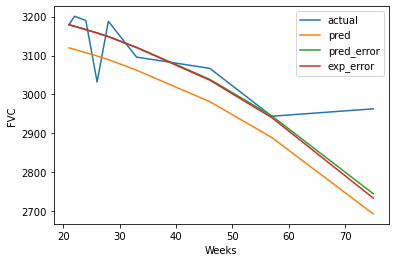

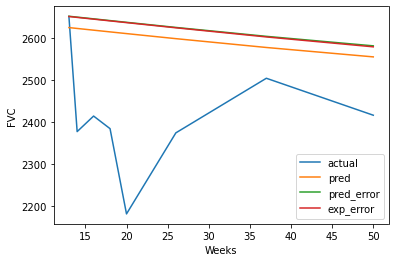

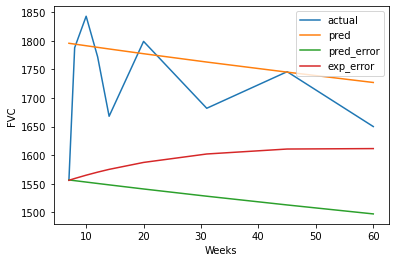

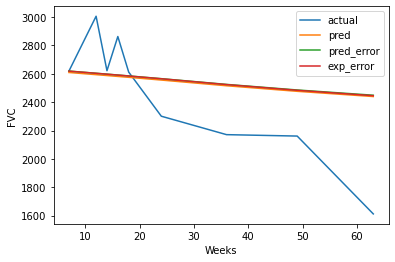

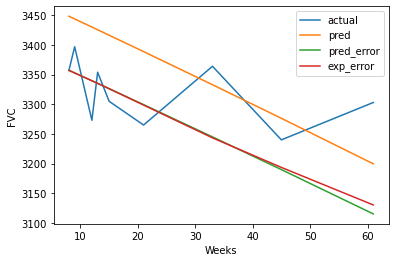

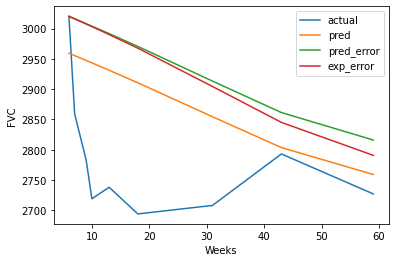

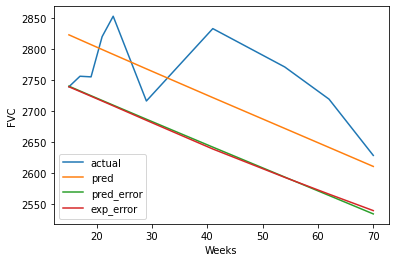

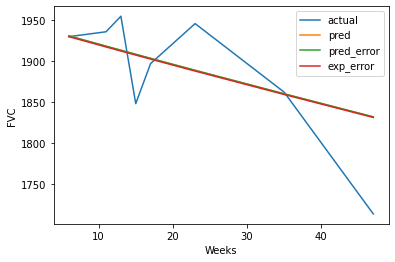

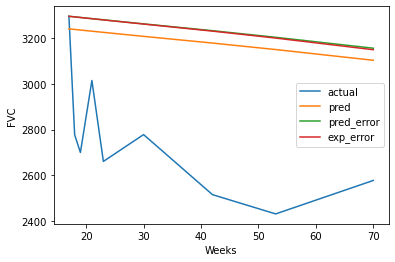

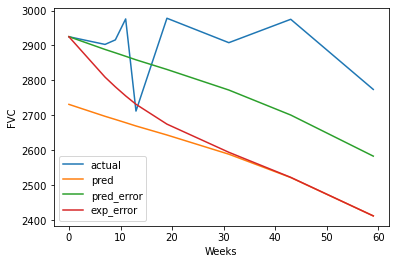

test


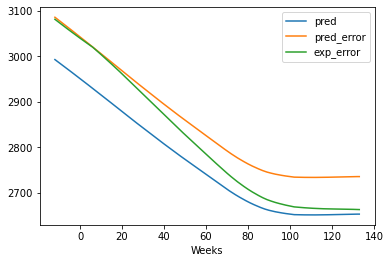

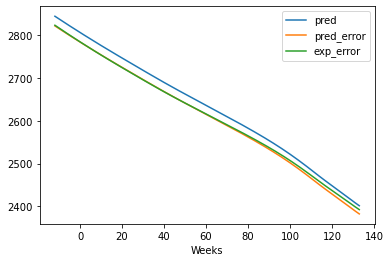

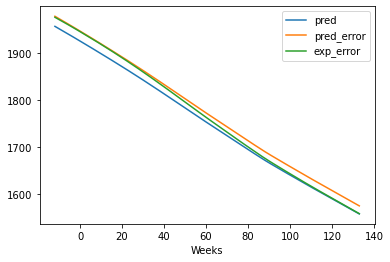

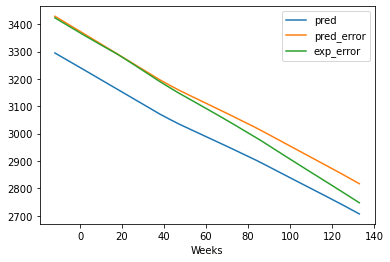

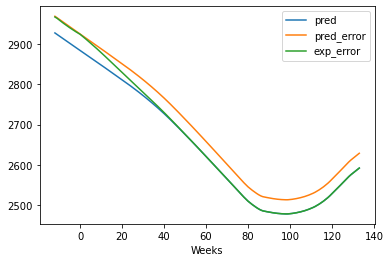

In [33]:
for ID in train.Patient.unique()[-10:]:
    train_id=train[train.Patient==ID]
    temp=train_preds_nn[train.Patient==ID]
    pred_error_=pred_error_nn[train.Patient==ID]
    exp_nn_=exp_nn[train.Patient==ID]
    sns.lineplot(train_id.Weeks,train_id.FVC)
    sns.lineplot(train_id.Weeks,temp)
    sns.lineplot(train_id.Weeks,pred_error_)
    sns.lineplot(train_id.Weeks,exp_nn_)
    plt.legend(['actual','pred','pred_error','exp_error'])
    plt.show()
print('test')
for ID in sub.Patient.unique():
    sub_ID=sub[sub.Patient==ID]
    sns.lineplot(sub_ID.Weeks,test_preds_nn[sub.Patient==ID])
    sns.lineplot(sub_ID.Weeks,pred_error_test_nn[sub.Patient==ID])
    sns.lineplot(sub_ID.Weeks,exp_test_nn[sub.Patient==ID])
    plt.legend(['pred','pred_error','exp_error'])
    plt.show()

1
FOLD1
The average val-loss for epoch 0 is 1248.52 and the val-score is 24.79810905456543

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.003494333242997527.
The average val-loss for epoch 250 is 72.96 and the val-score is 7.884134292602539

Epoch 00346: ReduceLROnPlateau reducing learning rate to 0.00468500005081296.

Epoch 00416: ReduceLROnPlateau reducing learning rate to 0.00512833334505558.

Epoch 00486: ReduceLROnPlateau reducing learning rate to 0.005571666639298201.
The average val-loss for epoch 500 is 60.42 and the val-score is 7.650448799133301

Epoch 00556: ReduceLROnPlateau reducing learning rate to 0.006014999933540821.

Epoch 00626: ReduceLROnPlateau reducing learning rate to 0.005289352033287287.

Epoch 00696: ReduceLROnPlateau reducing learning rate to 0.0032445290125906467.
The average val-loss for epoch 750 is 56.86 and the val-score is 7.645970344543457

Epoch 00766: ReduceLROnPlateau reducing learning rate to 0.001993972808122635.

Epoch 00836: ReduceL

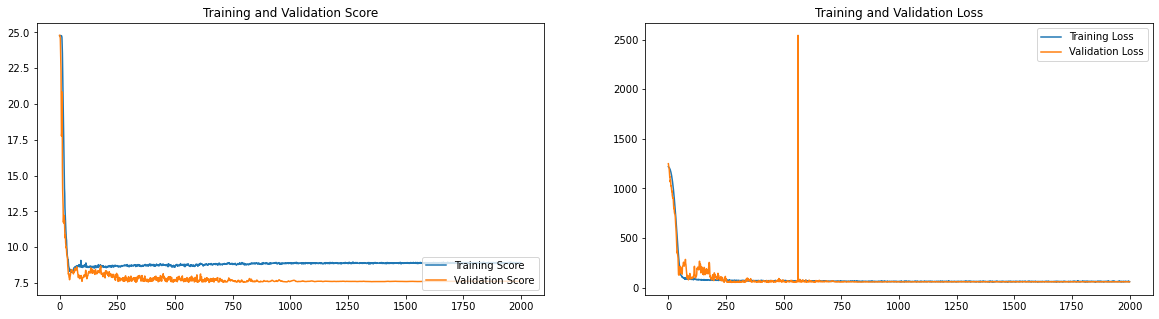

FOLD2
The average val-loss for epoch 0 is 1263.73 and the val-score is 24.779399871826172

Epoch 00230: ReduceLROnPlateau reducing learning rate to 0.003950333222746849.
The average val-loss for epoch 250 is 85.57 and the val-score is 7.713470935821533

Epoch 00397: ReduceLROnPlateau reducing learning rate to 0.005007999949157238.

Epoch 00467: ReduceLROnPlateau reducing learning rate to 0.0054513332433998585.
The average val-loss for epoch 500 is 93.90 and the val-score is 7.893772602081299

Epoch 00537: ReduceLROnPlateau reducing learning rate to 0.005894666537642479.

Epoch 00656: ReduceLROnPlateau reducing learning rate to 0.004289051052182913.

Epoch 00726: ReduceLROnPlateau reducing learning rate to 0.0026327730156481266.
The average val-loss for epoch 750 is 89.26 and the val-score is 7.9845709800720215

Epoch 00796: ReduceLROnPlateau reducing learning rate to 0.0016198402736335993.

Epoch 00866: ReduceLROnPlateau reducing learning rate to 0.0010003591887652874.

Epoch 00936: Re

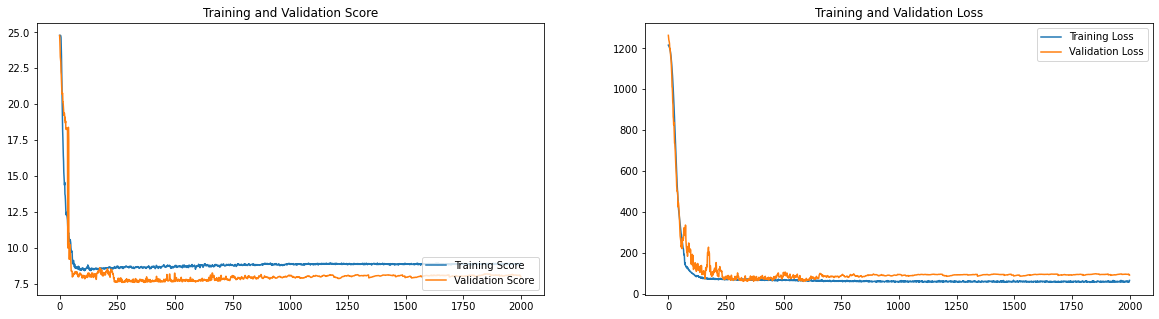

FOLD3
The average val-loss for epoch 0 is 1214.66 and the val-score is 24.79810905456543
The average val-loss for epoch 250 is 65.08 and the val-score is 7.891084671020508

Epoch 00338: ReduceLROnPlateau reducing learning rate to 0.004634333308786154.

Epoch 00408: ReduceLROnPlateau reducing learning rate to 0.005077666603028774.

Epoch 00478: ReduceLROnPlateau reducing learning rate to 0.005520999897271395.
The average val-loss for epoch 500 is 71.63 and the val-score is 7.7784318923950195

Epoch 00548: ReduceLROnPlateau reducing learning rate to 0.005964333191514015.

Epoch 00660: ReduceLROnPlateau reducing learning rate to 0.0041709053330123425.

Epoch 00730: ReduceLROnPlateau reducing learning rate to 0.0025605184491723776.
The average val-loss for epoch 750 is 64.88 and the val-score is 7.947775363922119

Epoch 00800: ReduceLROnPlateau reducing learning rate to 0.0015756514621898532.

Epoch 00870: ReduceLROnPlateau reducing learning rate to 0.0009733345359563828.

Epoch 00940: Red

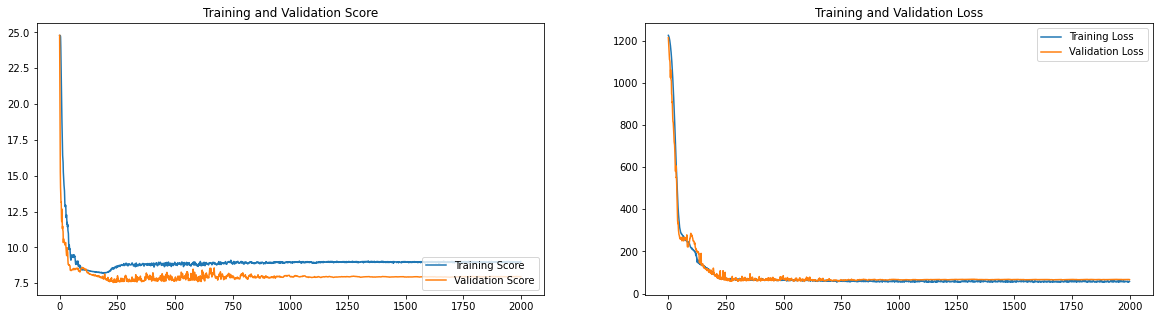

FOLD4
The average val-loss for epoch 0 is 1143.29 and the val-score is 24.79119300842285

Epoch 00246: ReduceLROnPlateau reducing learning rate to 0.004051666706800461.
The average val-loss for epoch 250 is 65.11 and the val-score is 7.577655792236328

Epoch 00329: ReduceLROnPlateau reducing learning rate to 0.004577333107590675.

Epoch 00399: ReduceLROnPlateau reducing learning rate to 0.005020666867494583.

Epoch 00469: ReduceLROnPlateau reducing learning rate to 0.005464000161737204.
The average val-loss for epoch 500 is 57.39 and the val-score is 7.623868942260742

Epoch 00666: ReduceLROnPlateau reducing learning rate to 0.003999796230345964.

Epoch 00736: ReduceLROnPlateau reducing learning rate to 0.0024558729492127895.
The average val-loss for epoch 750 is 62.63 and the val-score is 7.685346603393555

Epoch 00806: ReduceLROnPlateau reducing learning rate to 0.0015116531867533922.

Epoch 00876: ReduceLROnPlateau reducing learning rate to 0.0009341950644738972.

Epoch 00946: Reduc

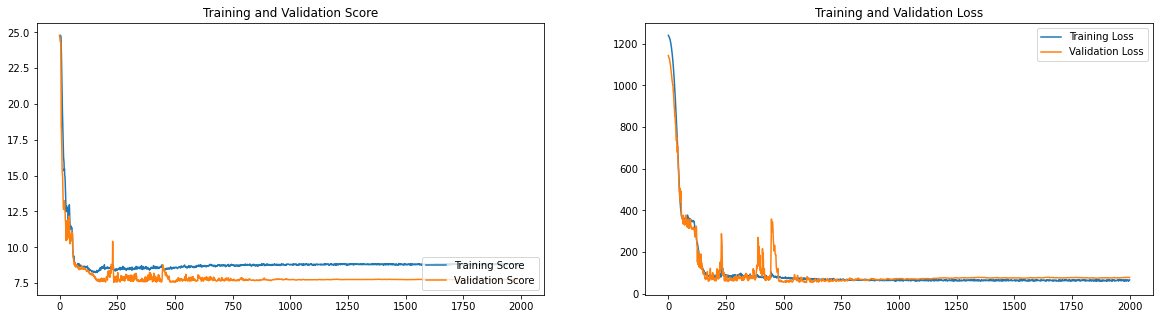

FOLD5
The average val-loss for epoch 0 is 1197.86 and the val-score is 24.764949798583984

Epoch 00218: ReduceLROnPlateau reducing learning rate to 0.003874333342537284.
The average val-loss for epoch 250 is 93.25 and the val-score is 7.660866737365723

Epoch 00335: ReduceLROnPlateau reducing learning rate to 0.004615333396941423.

Epoch 00405: ReduceLROnPlateau reducing learning rate to 0.005058666691184044.

Epoch 00497: ReduceLROnPlateau reducing learning rate to 0.005641333293169737.
The average val-loss for epoch 500 is 59.79 and the val-score is 7.801211833953857

Epoch 00617: ReduceLROnPlateau reducing learning rate to 0.005632918793708086.

Epoch 00687: ReduceLROnPlateau reducing learning rate to 0.003454644465819001.
The average val-loss for epoch 750 is 61.76 and the val-score is 7.785276412963867

Epoch 00757: ReduceLROnPlateau reducing learning rate to 0.002122473670169711.

Epoch 00827: ReduceLROnPlateau reducing learning rate to 0.0013077554758638144.

Epoch 00897: Reduce

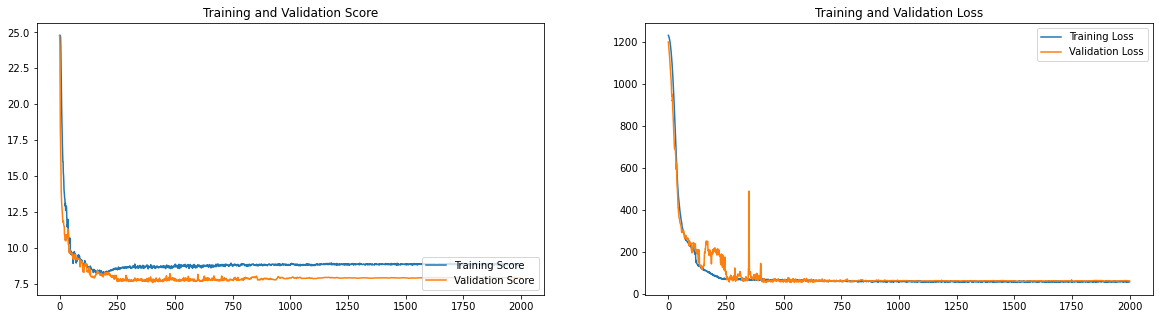

FOLD6
The average val-loss for epoch 0 is 1233.25 and the val-score is 24.739089965820312
The average val-loss for epoch 250 is 66.94 and the val-score is 7.808917999267578

Epoch 00306: ReduceLROnPlateau reducing learning rate to 0.004431666806340218.

Epoch 00414: ReduceLROnPlateau reducing learning rate to 0.005115666892379522.

Epoch 00484: ReduceLROnPlateau reducing learning rate to 0.005559000186622143.
The average val-loss for epoch 500 is 79.27 and the val-score is 7.950037956237793

Epoch 00554: ReduceLROnPlateau reducing learning rate to 0.006002333480864763.

Epoch 00624: ReduceLROnPlateau reducing learning rate to 0.00536383455619216.

Epoch 00694: ReduceLROnPlateau reducing learning rate to 0.00329007999971509.
The average val-loss for epoch 750 is 60.85 and the val-score is 7.719330310821533

Epoch 00825: ReduceLROnPlateau reducing learning rate to 0.0013259043917059898.

Epoch 00895: ReduceLROnPlateau reducing learning rate to 0.0008205963531509042.

Epoch 00965: ReduceL

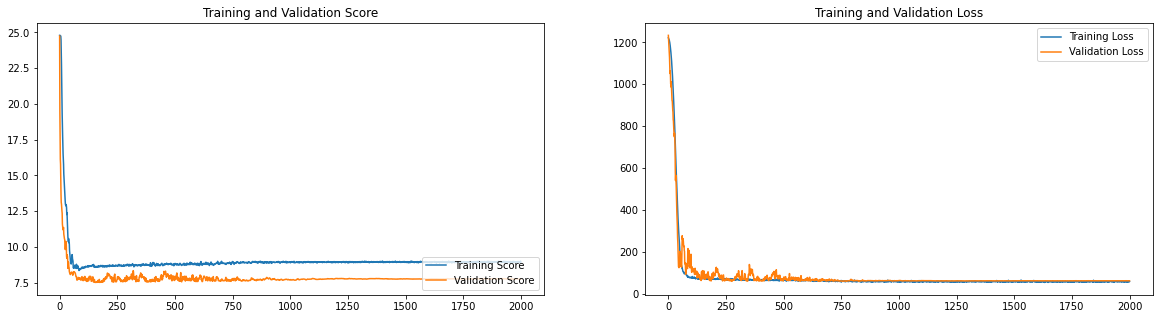

7.767099936803182


NameError: name 'final_score' is not defined

In [34]:
#neural with cinfidence
features=np.array(['Weeks','Ex-smoker','Never smoked','Age','STD_FVC','Sex_Label','skew_l1','skew_l2','skew_r1','skew_r2','mean_l1','mean_l2','mean_r1','mean_r2','kurt_l1','kurt_l2','kurt_r1','kurt_r2','Base_Percent','Base_Weeks','Base_FVC','Area_l1','Area_l2','Area_r1','Area_r2','Area'])
target=['FVC']
features_cat=['Ex-smoker','Never smoked']
features_numerical=np.array(['Sex_Label','Weeks','Age','STD_FVC','skew_l1','skew_l2','skew_r1','skew_r2','mean_l1','mean_l2','mean_r1','mean_r2','kurt_l1','kurt_l2','kurt_r1','kurt_r2','Base_Percent','Base_Weeks','Base_FVC','Area_l1','Area_l2','Area_r1','Area_r2','Area'])
#hyperparamter
if(test.shape[0]>5):
    RUN=3
else:
    RUN=1
print(RUN)
EPOCHS = 2000
BATCH_SIZE=252
Drop_1=0.395458
Drop_2=0.200271
Drop_3= 0.2#463196
FOLDS=6
Factor=0.25#54209
_lambda=0.748637
lr=0.00320555
patience=70#patience=99
#mean_OOF_val_score=7.72143
Quantile_1 =0.275231
Quantile_3=0.826674
#######################################

temp_1=train.copy()
temp_2=sub.copy()
data=pd.concat([temp_1,temp_2],axis=0)
temp_1[features_numerical]=(temp_1[features_numerical]-data[features_numerical].mean())/data[features_numerical].std()
temp_2[features_numerical]=(temp_2[features_numerical]-data[features_numerical].mean())/data[features_numerical].std()
X_train=temp_1[features].values#((temp-temp.mean())/temp.std()).values
y_train=temp_1[target].values
X_test = temp_2[features].values
train_preds = np.zeros((X_train.shape[0],3))
test_preds = np.zeros((X_test.shape[0],3))
y_train=y_train.astype(np.float64)
#################################################################
from scipy.optimize import minimize

def score(sigma,FVC_true,FVC_pred):
    delta=np.where(np.abs(FVC_true-FVC_pred)>1000,1000,np.abs(FVC_true-FVC_pred))
    sigma_clipped=np.where(sigma>70,sigma,70)
    sqrt_2=np.sqrt(2)
    return sqrt_2*delta/sigma_clipped+np.log(sqrt_2*sigma_clipped)

def pediction_error(data,pred):
    predict_error=[]
    error_ID=[]
    b_exp_=[]
    for ID in data.Patient.unique():
        temp=data[data.Patient==ID].copy()
        predict=pred[temp.index]
        #predict=predict*(temp['STD_FVC'].values)/100
        temp['FVC_pred']=predict
        base_week,base_fvc,fvc_pred=temp.loc[temp.Weeks==temp.Base_Weeks.values[0]][['Base_Weeks','Base_FVC','FVC_pred']].values[0]
        if(fvc_pred!=0):
            error=int(base_fvc)/int(fvc_pred)
            predict=predict*error
        else:
            error=base_fvc-fvc_pred
            predict=predict+error
            print('zero__')
        
        error_exp=base_fvc-fvc_pred
        Weeks=temp.Weeks.values
        b=pred[data.Patient==ID]
        exp=np.exp(-np.abs(base_week-Weeks)/(np.abs(base_week)+1)*(np.abs(base_fvc-b)/base_fvc))
        exp_error=exp*error_exp
        b_exp=b+exp_error #pred_error[train.Patient==ID]
        
        b_exp_.append(b_exp)
        predict_error.append(predict)
        error_ID.append([ID,error])
    b_exp_=np.hstack(b_exp_)
    predict_error=np.hstack(predict_error)
    return predict_error,b_exp_,error_ID
def prediction_df(data,pred):
    actual=data['FVC'].values
    score_min=[]
    for p,a in zip(pred,actual):
        m=minimize(score,70, args=(a,p))
        score_min.append([m.x[0],m.fun])
    score_min=np.array(score_min)
    prediction_df=pd.DataFrame({'FVC':actual,'FVC_pred':pred,'Diff':np.abs(actual-pred),'Confidence':score_min[:,0],'score':score_min[:,1]})
    prediction_df['FVC']=actual
    prediction_df['FVC_pred']=pred
    prediction_df['Diff']=np.abs(actual-pred)
    prediction_df['Confidence']=score_min[:,0]
    prediction_df['score']=score_min[:,1]
    #print(prediction_df.score.mean())
    return prediction_df


def plot_history(history):
    score = history.history['metric']
    val_score = history.history['val_metric']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    # create subplots
    plt.figure(figsize = (20,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, score, label = 'Training Score')
    plt.plot(epochs_range, val_score, label = 'Validation Score')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Score')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    # limit y-values for beter zoom-scale
    #plt.ylim(0.3 * np.mean(val_loss), 1.8 * np.mean(val_loss))

    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def get_lr_callback(batch_size=64,plot=False):
    LR_START=0.01
    LR_MAX= 0.0001*batch_size
    LR_MIN=0.0001
    ######
    LR_RAMP_EP=EPOCHS*0.3
    LR_SUS_EP  = 0
    LR_DECAY   = 0.993

    def lr_scheduler(epoch):
        if(epoch<LR_RAMP_EP):
            lr=(LR_MAX-LR_START)/LR_RAMP_EP*epoch+LR_START
        elif(epoch<LR_RAMP_EP+LR_SUS_EP):
            lr=LR_MAX
        else:
            lr=(LR_MAX-LR_MIN)*LR_DECAY**(epoch-LR_RAMP_EP-LR_SUS_EP)+LR_MIN
        return lr
    if(plot==False):
        lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_scheduler,verbose=False)
        return lr_callback
    else:
        return lr_scheduler

#custom callbacks
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_score=[]
        
    def on_epoch_end(self, epoch, logs=None):
        self.val_score.append(logs['val_metric'])
        if epoch % 250 == 0 or epoch == (EPOCHS -1 ):
            print(f"The average val-loss for epoch {epoch} is {logs['val_loss']:.2f}"
                  f" and the val-score is {logs['val_metric']}")

    def on_train_end(self, logs=None):
        best_epoch = np.argmin(self.val_score)
        # get score in best epoch
        best_score = self.val_score[best_epoch]
        print(f"Stop training, best model was found and saved in epoch {best_epoch + 1} with val-score: {best_score}."
              f" Final results in this fold (last epoch):") 

def get_checkpoint_saver_callback(fold):
    checkpt_saver = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold,
        monitor = 'val_loss',
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = 'min',
        save_freq = 'epoch')
    
    return checkpt_saver

#######################################
def metric(y_true,y_pred):
    sigma_min,max_error_FVC=tf.constant(70,dtype='float32'),tf.constant(1000,dtype='float32')
    tf.dtypes.cast(y_true,tf.float32)
    tf.dtypes.cast(y_pred,tf.float32)
    sigma=y_pred[:,-1]-y_pred[:,0]
    fvc_pred=y_pred[:,1]
    sigma_clipped=tf.maximum(sigma,sigma_min)
    delta=tf.abs(fvc_pred-y_true)
    delta=tf.minimum(delta,max_error_FVC)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype = tf.float32))
    metric_ = (delta / sigma_clipped) * sq2 + tf.math.log(sigma_clipped * sq2)
    return K.mean(metric_)


def qloss(y_true,y_pred,Quantile_1,Quantile_3):
    qs=[Quantile_1,0.5,Quantile_3]
    qs=tf.constant(np.array(qs),dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(qs* e, (qs-1) * e)
    threshold=200
    v=tf.math.abs(v)
    if(K.mean(v)<threshold):
        v=K.mean(v)
    else:
        v=tf.math.square(v)
        v=K.mean(v)
        v=K.sqrt(v)
    return v

def mloss(_lambda,Quantile_1,Quantile_3):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred,Quantile_1,Quantile_3) + (1 - _lambda) * metric(y_true, y_pred)
    return loss




import tensorflow_addons as tfa
def model(Drop_1,Drop_2,Drop_3,_lambda,Quantile_1,Quantile_3,lr=0.01,optimizer='Adam'):
    Input=layers.Input((len(features),))
    x=layers.BatchNormalization()(Input)
    x=tfa.layers.WeightNormalization(layers.Dense(256,activation='elu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.4)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(128,activation='elu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.2)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(64,activation='elu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.2)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(32,activation='elu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.1)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(32,activation='elu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.1)(x)
    q1=layers.Dense(3,activation='relu')(x)
    q2=layers.Dense(3,activation='relu')(x)#this will make sure the prediction is in order x<y<z
    pred=layers.Lambda(lambda x:x[0]+tf.cumsum(x[1],axis=1))([q1,q2])
    model_neural=Models.Model(Input,pred)
    
    optimizer=tf.keras.optimizers.Adam(lr=lr) if optimizer=='Adam' else tf.keras.optimizers.SGD()
    _lamda=tf.constant(_lambda,dtype=tf.float32)
    model_neural.compile(loss=mloss(_lamda,Quantile_1,Quantile_3),optimizer=optimizer,metrics=[metric])
    #print(Drop_1,Drop_2,Drop_3,_lambda,Quantile_1,Quantile_3)
    return model_neural

for i in range(RUN):
    #group wise K-Fold 'Patient_ID'
    callbacks=[]
    LOGGING=True
    gkf=GroupKFold(n_splits=FOLDS)
    groups=train.Patient.values
    fold=0
    OOF_val_score=[]
    for train_idx,val_idx in gkf.split(X_train,y_train,groups=groups):
        fold+=1
        print(f"FOLD{fold}")
        callbacks_lr = [get_lr_callback(BATCH_SIZE)]
        reduce_lr_loss=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=Factor,patience=patience,verbose = 1,epsilon = 1e-4,mode = 'min',min_lr = 0.00001)
        #reduce_lr_loss if the model reached to some plateau or loss is not decreasing then LR is reduced so that it won't overshoot#0.23889#50
        callbacks=[reduce_lr_loss]
        if(LOGGING==True):
            callbacks +=  [get_checkpoint_saver_callback(fold),                   
                         CustomCallback(),callbacks_lr]


        model_neural = model(Drop_1,Drop_2,Drop_3,_lambda,Quantile_1,Quantile_3,lr,'Adam')
        history = model_neural.fit(X_train[train_idx], y_train[train_idx], 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (X_train[val_idx], y_train[val_idx]),
                  callbacks = callbacks,verbose = 0)

        
        model_neural.load_weights('fold-%i.h5'%fold)
        print("Train:", model_neural.evaluate(X_train[train_idx], y_train[train_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
        print("Val:", model_neural.evaluate(X_train[val_idx], y_train[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
        print('Abs_error',np.abs(model_neural.predict(X_train[val_idx])[:,1]-y_train[val_idx]).mean())
        train_preds[val_idx]=train_preds[val_idx]+ model_neural.predict(X_train[val_idx],
                                             batch_size = BATCH_SIZE,
                                             verbose = 0)
        
        OOF_val_score.append(model_neural.evaluate(X_train[val_idx], y_train[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True)['metric'])
        print("Predicting Test...") 
        plot_history(history)
        test_preds += model_neural.predict(X_test, batch_size = BATCH_SIZE, verbose = 0)/FOLDS
    print(np.mean(OOF_val_score))
    ############
    abs_mean=np.abs(train_preds[:,1]/(i+1)-train['FVC'].values).mean()
    sigma=(train_preds[:,-1]-train_preds[:,0])/(i+1)
    FVC_pred=train_preds[:,1]/(i+1)
    FVC_actual=train['FVC'].values
    score_mean=score(sigma,FVC_actual,FVC_pred).mean()
    ##################
    sigma_error=(train_preds[:,-1]-train_preds[:,0])*0.707/(i+1)
    pred_error,_,error= pediction_error(train,train_preds[:,1]/(i+1))
    FVC_pred=pred_error
    FVC_actual=train['FVC'].values
    abs_mean_error=np.abs(FVC_pred-train['FVC'].values).mean()
    score_error=score(sigma,FVC_actual,FVC_pred).mean()
    sigma_error_min_max=sigma.min(),sigma.max()
    pred_error_min_max=pred_error.min(),pred_error.max()
    array=[i,np.mean(OOF_val_score),abs_mean,score_mean,abs_mean_error,score_error,sigma_error_min_max,pred_error_min_max]
    final_score.append(array)
train_preds=train_preds/RUN
test_preds=test_preds/RUN

In [35]:
temp=train.copy()
temp['sigma']=train_preds[:,-1]-train_preds[:,0]
temp['FVC_pred']=train_preds[:,1]
temp.head(50)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,STD_FVC,Age_Week,Sex_Label,...,Area_r2,Currently smokes,Ex-smoker,Never smoked,Base_Percent,Base_FVC,Base_Weeks,Area,sigma,FVC_pred
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,3974.0,78.92,79,...,81772.929086,0,1,0,58.253649,2315,-4,413252.944812,323.404053,2170.729004
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,3974.0,79.10,79,...,81772.929086,0,1,0,58.253649,2315,-4,413252.944812,321.396240,2145.659180
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,3974.0,79.15,79,...,81772.929086,0,1,0,58.253649,2315,-4,413252.944812,320.739014,2137.455811
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,3974.0,79.19,79,...,81772.929086,0,1,0,58.253649,2315,-4,413252.944812,319.918579,2127.195557
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,3974.0,79.23,79,...,81772.929086,0,1,0,58.253649,2315,-4,413252.944812,318.978760,2115.455811
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker,3974.0,79.35,79,...,81772.929086,0,1,0,58.253649,2315,-4,413252.944812,315.691895,2074.830078
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker,3974.0,79.60,79,...,81772.929086,0,1,0,58.253649,2315,-4,413252.944812,308.793213,1991.905762
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker,3974.0,79.85,79,...,81772.929086,0,1,0,58.253649,2315,-4,413252.944812,304.310791,1939.482788
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker,3974.0,80.19,79,...,81772.929086,0,1,0,58.253649,2315,-4,413252.944812,302.856201,1922.539673
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,4291.6,69.17,79,...,193197.569181,0,1,0,85.282878,3660,8,809500.634563,529.506104,3498.363281


In [36]:
np.array(pediction_error(sub,test_preds[:,1])[2])#[:,-1].astype(int).mean()

array([['ID00419637202311204720264', '1.0596491228070175'],
       ['ID00421637202311550012437', '0.989880737260571'],
       ['ID00422637202311677017371', '1.004162330905307'],
       ['ID00423637202312137826377', '1.0708712613784135'],
       ['ID00426637202313170790466', '1.011760636457973']], dtype='<U25')

In [38]:
test_preds

array([[2781.58346558, 2930.8611145 , 3192.87890625],
       [2776.25979614, 2925.30661011, 3186.92028809],
       [2771.0140686 , 2919.834198  , 3181.05059814],
       ...,
       [2583.09869385, 2725.75085449, 2974.30218506],
       [2584.19006348, 2726.95309448, 2975.66333008],
       [2584.98483276, 2727.84542847, 2976.69363403]])

In [39]:
pd.DataFrame(train_preds).to_csv('train_preds.csv',index=False)
pd.DataFrame(train_preds_nn).to_csv('train_preds_nn.csv',index=False)

In [40]:
def pediction_error(data,train_preds):
    predict_error=[]
    b_exp_=[]
    error_ID=[]
    pred=train_preds[:,1]
    sigma=train_preds[:,-1]-train_preds[:,0]
    for ID in data.Patient.unique():
        temp=data[data.Patient==ID].copy()
        sigma_=sigma[data.Patient==ID]
        predict=pred[temp.index]
        temp['FVC_pred']=predict
        base_week,base_fvc,fvc_pred=temp.loc[temp.Weeks==temp.Base_Weeks.values[0]][['Base_Weeks','Base_FVC','FVC_pred']].values[0]
        sigma_[temp.Weeks==temp.Base_Weeks.values[0]]=70
        #print(70/sigma_error)
        sigma[data.Patient==ID]=sigma_
        if(fvc_pred!=0):
            error=int(base_fvc)/int(fvc_pred)
            predict=predict*error
        else:
            error=base_fvc-fvc_pred
            predict=predict*error
        
        error_exp=base_fvc-fvc_pred
        Weeks=temp.Weeks.values
        b=pred[data.Patient==ID]
        exp=np.exp(-np.abs(base_week-Weeks)/(np.abs(base_week)+1)*(np.abs(base_fvc-b)/base_fvc))
        exp_error=exp*error_exp
        b_exp=b+exp_error #pred_error[train.Patient==ID]
        
        b_exp_.append(b_exp)
        predict_error.append(predict)
        error_ID.append([ID,error])
    predict_error=np.hstack(predict_error)
    b_exp_=np.hstack(b_exp_)
    return predict_error,b_exp_,error_ID,sigma

In [41]:
train_pred_avg=(train_preds[:,0]+train_preds[:,2])/2
pred_error,exp_error,error,se= pediction_error(train,train_preds)

In [42]:
avg_pred_train=(exp_error+exp_nn)*0.5

In [43]:
print(np.abs(train_preds[:,1]-train['FVC'].values).mean())
print(np.abs(avg_pred_train-train['FVC'].values).mean())
sigma=(train_preds[:,-1]-train_preds[:,0])
FVC_pred=train_preds[:,1]
FVC_actual=train['FVC'].values
print(score(sigma,FVC_actual,FVC_pred).mean())
print(score(sigma*0.707,FVC_actual,FVC_pred).mean())
print(score(sigma,FVC_actual,avg_pred_train).mean())

166.33851064706778
143.6309117376368
6.92899859754732
6.839803040897818
6.839168634075305


In [44]:
pred_error_test,exp_test,error,se_test= pediction_error(sub,test_preds)

In [45]:
pred_error_test_nn,exp_test_nn
pred_error_test,exp_test,error,se_test

(array([3105.68440905, 3099.79858334, 3093.99974665, 3088.2909064 ,
        3082.67254767, 3077.15388676, 3071.77311476, 3066.56159946,
        3061.51261457, 3056.62787401, 3051.94676535, 3047.47203733,
        3043.16255611, 3038.98967028, 3034.9260543 , 3030.99929242,
        3027.2090936 , 3023.54423657, 3020.00692032, 3016.58149328,
        3013.24499555, 3010.01534231, 3006.89185448, 3003.84416675,
        3000.85808277, 2997.96681358, 2995.15642154, 2992.4164615 ,
        2989.75475924, 2987.15666568, 2984.61671571, 2982.13251632,
        2979.69753525, 2977.30278256, 2974.9434399 , 2972.61756699,
        2970.32513149, 2968.06558367, 2965.8374683 , 2963.63726057,
        2961.46518683, 2959.32085903, 2957.20175481, 2955.09128482,
        2952.98087951, 2950.87335226, 2948.78095917, 2946.70683701,
        2944.65108279, 2942.61304974, 2940.59241451, 2938.58830395,
        2936.60149418, 2934.63159715, 2932.67463529, 2930.7324842 ,
        2928.80895975, 2926.91240513, 2925.03835

In [46]:
#pred_error=np.where(train_preds[:,1]>5000,train_preds[:,1],pred_error)
print('pred_error',np.abs(pred_error-train['FVC'].values).mean())
print('exp_error',np.abs(exp_error-train['FVC'].values).mean())
sigma=(train_preds[:,-1]-train_preds[:,0])
FVC_pred=pred_error
FVC_actual=train['FVC'].values
print(score(sigma,FVC_actual,FVC_pred).mean())
print(score(sigma,FVC_actual,exp_error).mean())
print(score(sigma,FVC_actual,avg_pred_train).mean())

pred_error 147.84647753279933
exp_error 145.74494451090007
6.85135837274511
6.848185785866534
6.839168634075305


In [47]:
sigma=(train_preds[:,-1]-train_preds[:,0])
array=[[i,score(sigma*i,FVC_actual,train_preds[:,1]).mean()] for i in np.linspace(0,1,10000)]
array=np.array(array)
factor_,metric_=array[np.argmin(array[:,1])]
print(factor_,metric_)

0.6213621362136214 6.831824229909431


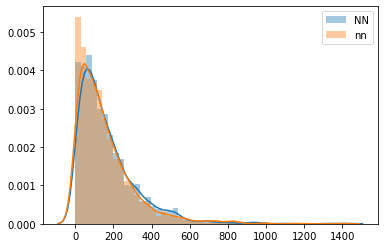

In [48]:
sns.distplot(np.abs(train.FVC.values-train_preds[:,1]))
sns.distplot(np.abs(train.FVC.values-train_preds_nn))
plt.legend(['NN','nn'])

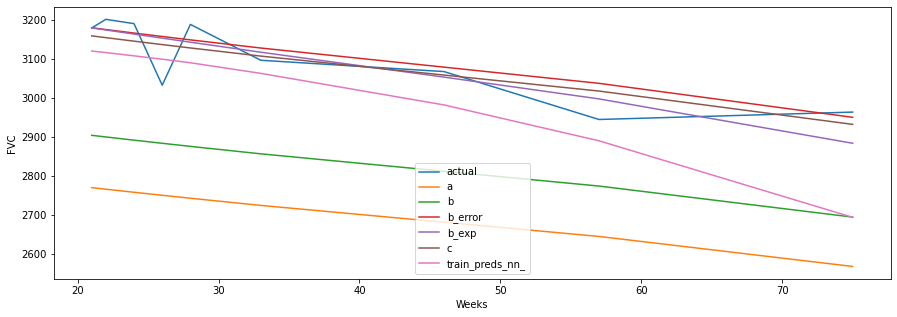

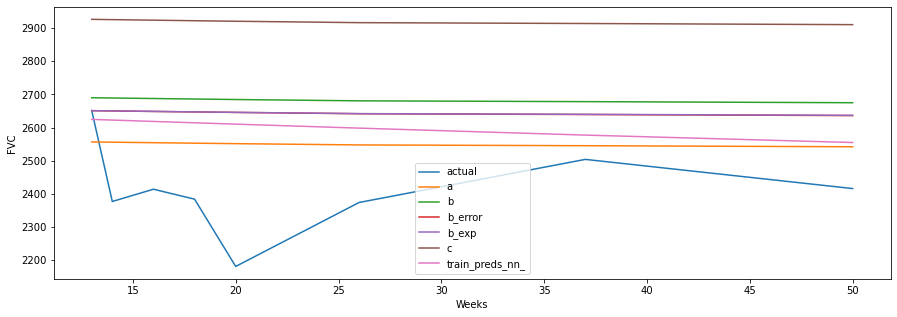

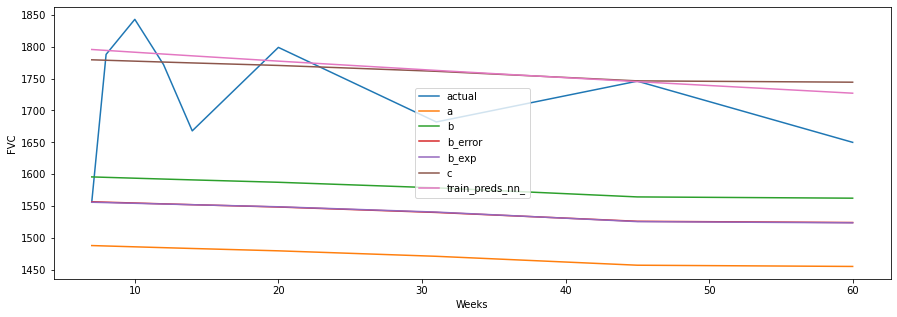

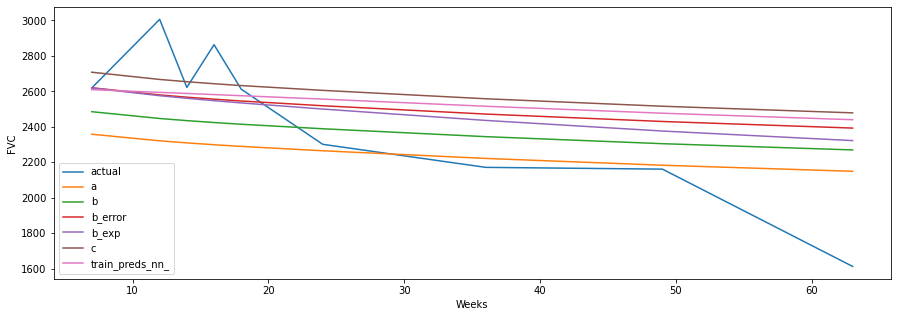

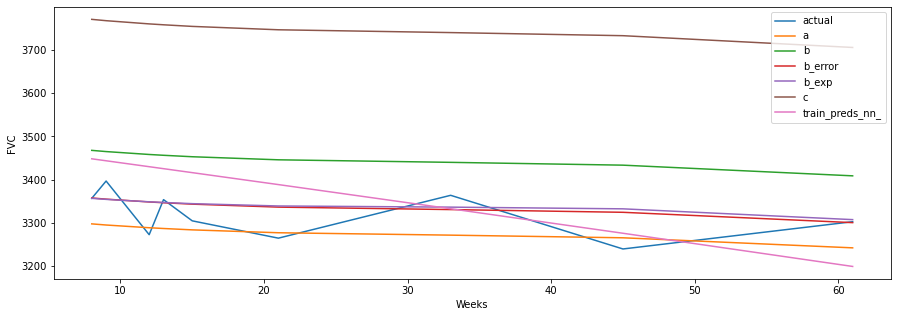

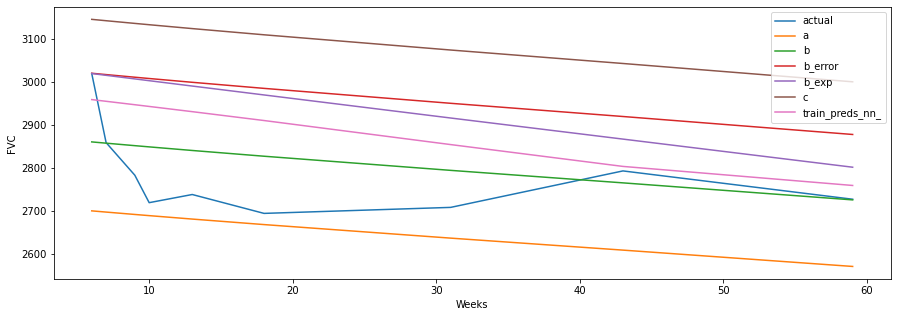

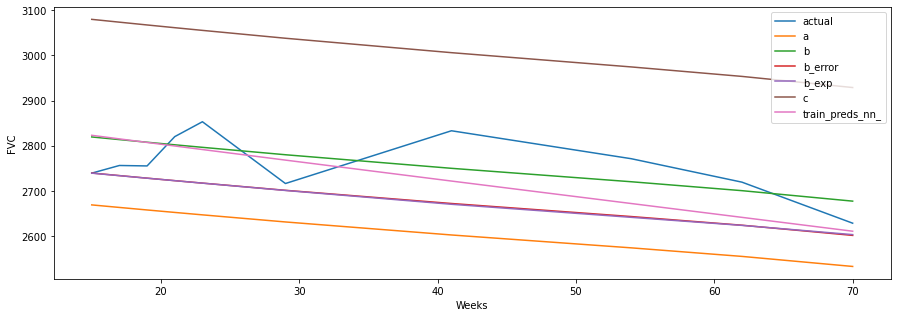

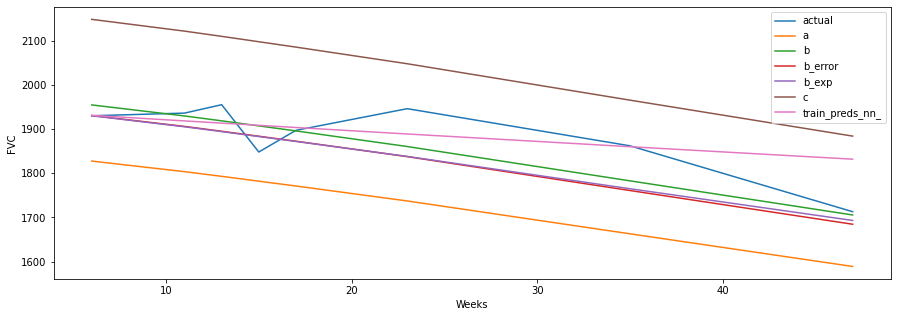

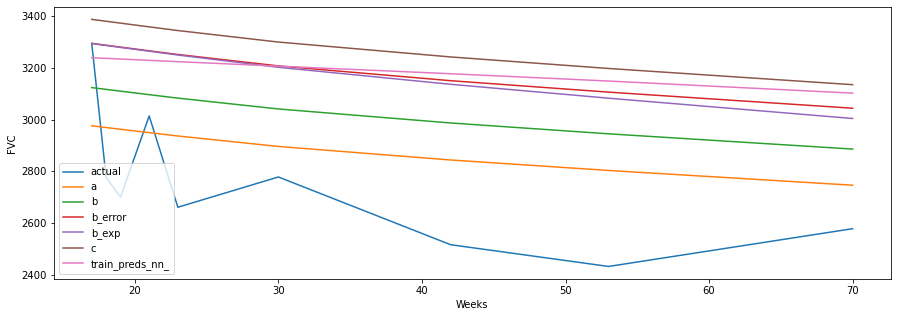

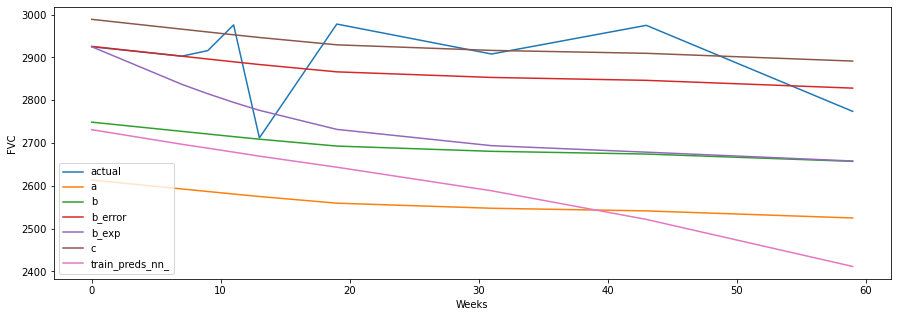

In [49]:
for ID in train.Patient.unique()[-10:]:
    train_id=train[train.Patient==ID]
    pred_error_=pred_error[train.Patient==ID]
    b_exp_=exp_error[train.Patient==ID]
    Weeks=train_id.Weeks.values
    Week_min=np.min(Weeks)
    temp=train_preds[train.Patient==ID]
    train_preds_nn_=train_preds_nn[train.Patient==ID]
    plt.figure(figsize=(15,5))
    a,b,c=temp[:,0],temp[:,1],temp[:,2]
    sns.lineplot(train_id.Weeks,train_id.FVC)
    sns.lineplot(train_id.Weeks,a)
    sns.lineplot(train_id.Weeks,b)
    sns.lineplot(train_id.Weeks,pred_error_)
    sns.lineplot(train_id.Weeks,b_exp_)
    sns.lineplot(train_id.Weeks,c)
    sns.lineplot(train_id.Weeks,train_preds_nn_)
    plt.legend(['actual','a','b','b_error','b_exp','c','train_preds_nn_'])
    plt.show()

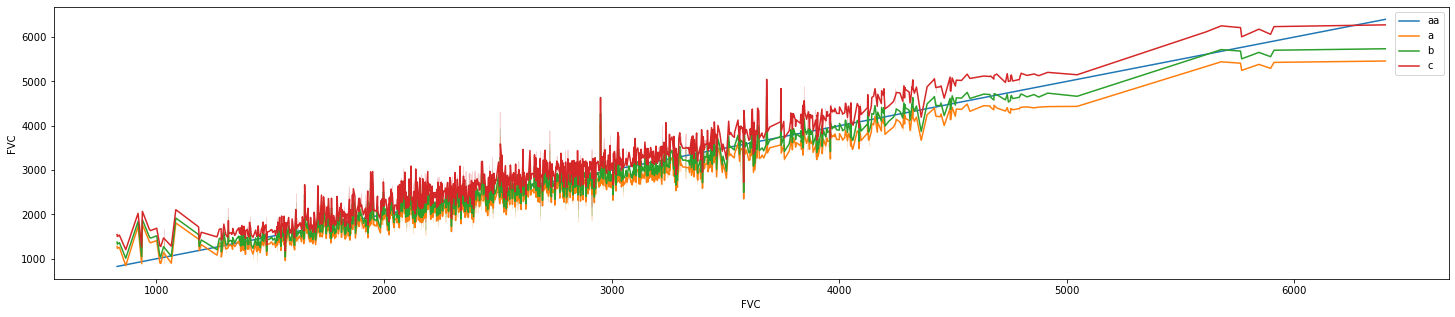

In [50]:
plt.figure(figsize=(25,5))
sns.lineplot(train.FVC,train.FVC)
sns.lineplot(train.FVC,train_preds[:,0])
sns.lineplot(train.FVC,train_preds[:,1])
sns.lineplot(train.FVC,train_preds[:,2])
plt.legend(['aa','a','b','c'])
plt.show()

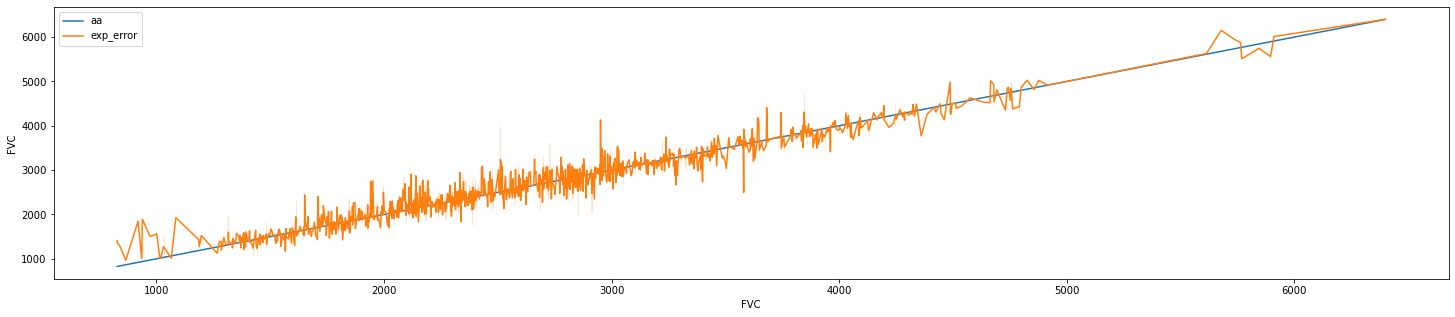

In [51]:
plt.figure(figsize=(25,5))
sns.lineplot(train.FVC,train.FVC)
sns.lineplot(train.FVC,exp_error)
plt.legend(['aa','exp_error'])
plt.show()

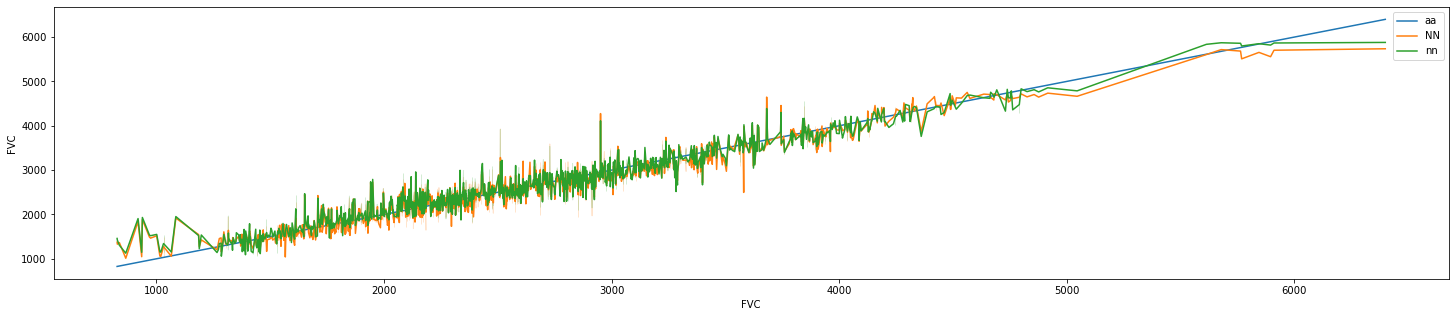

In [52]:
plt.figure(figsize=(25,5))
sns.lineplot(train.FVC,train.FVC)
sns.lineplot(train.FVC,train_preds[:,1])
sns.lineplot(train.FVC,train_preds_nn)
plt.legend(['aa','NN','nn'])
plt.show()

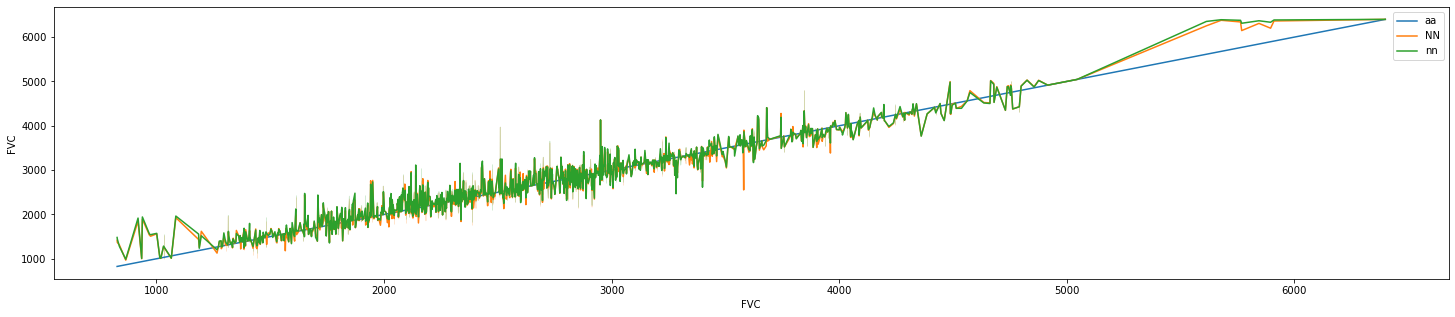

In [53]:
plt.figure(figsize=(25,5))
sns.lineplot(train.FVC,train.FVC)
sns.lineplot(train.FVC,pred_error)
sns.lineplot(train.FVC,pred_error_nn)
plt.legend(['aa','NN','nn'])
plt.show()

In [54]:
avg_pred_exp=(exp_error+exp_nn)/2

In [55]:
print(np.abs(train.FVC.values-avg_pred_exp).mean())

143.6309117376368


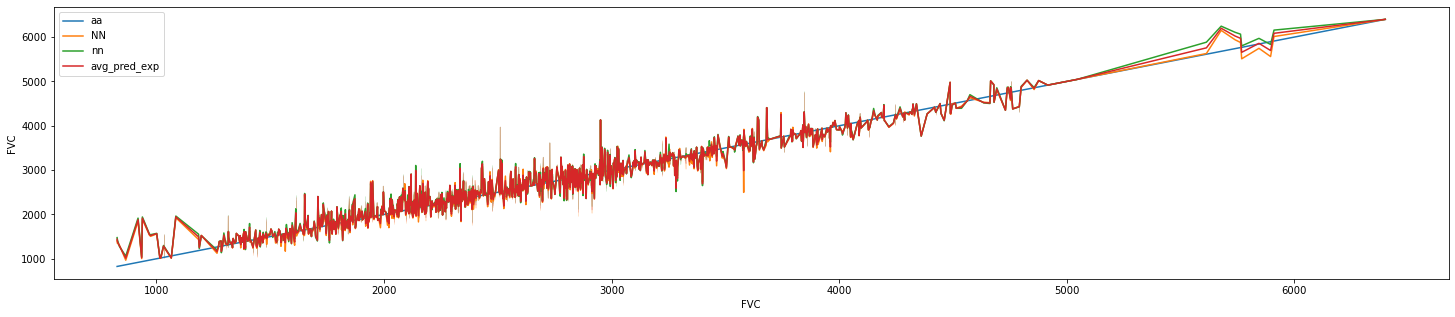

In [56]:
plt.figure(figsize=(25,5))
sns.lineplot(train.FVC,train.FVC)
sns.lineplot(train.FVC,exp_error)
sns.lineplot(train.FVC,exp_nn)
sns.lineplot(train.FVC,avg_pred_exp)
plt.legend(['aa','NN','nn','avg_pred_exp'])
plt.show()

In [57]:
def temp_score(abs_,cnf):
    abs_=np.where(abs_>1000,1000,abs_)
    cnf=np.where(cnf<70,70,cnf)
    sqrt=np.sqrt(2)
    return (sqrt*abs_)/cnf+np.log(sqrt*cnf)
FVC_true=train.FVC
FVC_pred,_,_,_=pediction_error(train,train_preds)#pred_error#train_preds[:,1]
#df=prediction_df(train,FVC_pred)
df=train[['Patient','FVC']].copy()
df['FVC_pred']=train_preds[:,1]
df['diff']=np.abs(train_preds[:,1]-train.FVC.values)
df['diff_2']=df['diff'].values*2
df['score_actual']=temp_score(df['diff'].values,df['diff_2'].values)
df['Confidence_pred']=train_preds[:,-1]-train_preds[:,0]
df['score_pred']=temp_score(df['diff'].values,df['Confidence_pred'].values)
c=train_preds[:,2]
b=train_preds[:,1]
a=train_preds[:,0]
df['Confidence_pred_2']=(np.where((b-a)<(c-b),c-b,b-a))
df['Confidence_pred_sqrt2']=(np.where((b-a)<(c-b),c-b,b-a))#*0.4767321927316698/2
df['score_pred_2']=temp_score(df['diff'].values,df['Confidence_pred_2'].values)
df['score_pred_sqrt2']=temp_score(df['diff'].values,df['Confidence_pred_sqrt2'].values)
#t1=df.Confidence
#t2=df.Confidence_pred
#df['Scaled_Confidence']=t1.std()*((t2-t2.mean())/t2.std())+t1.mean()
#df['Avg']=np.abs(train_preds[:,1]-train_pred_avg)
df['p1']=train_preds[:,0]
df['p2']=train_preds[:,2]
df['std']=np.std(train_preds,axis=1)
df.head(50)
#sigma=df['Confidence'].astype(int)#test_preds[:,-1]-test_preds[:,0]#np.std(train_preds,axis=1)#[:,0]-test_preds[:,-1])
#FVC_pred=df.FVC_pred#test_preds[:,1]#np.mean(test_preds,axis=1)
#FVC_actual=train['FVC'].values
#print(score(sigma,FVC_actual,FVC_pred).mean())

,Patient,FVC,FVC_pred,diff,diff_2,score_actual,Confidence_pred,score_pred,Confidence_pred_2,Confidence_pred_sqrt2,score_pred_2,score_pred_sqrt2,p1,p2,std
0,ID00007637202177411956430,2315,2170.729004,144.270996,288.541992,6.718521,323.404053,6.756359,209.783936,209.783936,6.665224,6.665224,2057.108887,2380.512939,133.960613
1,ID00007637202177411956430,2214,2145.659180,68.340820,136.681641,5.971335,321.396240,6.419963,208.381348,208.381348,6.149749,6.149749,2032.644287,2354.040527,133.120954
2,ID00007637202177411956430,2061,2137.455811,76.455811,152.911621,6.083540,320.739014,6.454313,207.922363,207.922363,6.203763,6.203763,2024.639160,2345.378174,132.846118
3,ID00007637202177411956430,2144,2127.195557,16.804443,33.608887,4.934570,319.918579,6.188925,207.350098,207.350098,5.795596,5.795596,2014.627075,2334.545654,132.503091
4,ID00007637202177411956430,2069,2115.455811,46.455811,92.911621,5.585329,318.978760,6.317663,206.694580,206.694580,5.995669,5.995669,2003.171631,2322.150391,132.110154
5,ID00007637202177411956430,2101,2074.830078,26.169922,52.339844,5.123781,315.691895,6.218574,204.398193,204.398193,5.847711,5.847711,1963.536377,2279.228271,130.735646
6,ID00007637202177411956430,2000,1991.905762,8.094238,16.188477,4.758597,308.793213,6.116315,199.554688,199.554688,5.700025,5.700025,1882.667236,2191.460449,127.849033
7,ID00007637202177411956430,2064,1939.482788,124.517212,249.034424,6.571272,304.310791,6.643288,196.390503,196.390503,6.523331,6.523331,1831.562500,2135.873291,125.972253
8,ID00007637202177411956430,2057,1922.539673,134.460327,268.920654,6.648097,302.856201,6.687706,195.361938,195.361938,6.594778,6.594778,1815.045410,2117.901611,125.363109
9,ID00009637202177434476278,3660,3498.363281,161.636719,323.273438,6.832179,529.506104,7.050220,337.895020,337.895020,6.845817,6.845817,3306.752197,3836.258301,218.902456


In [58]:
df.describe()

,FVC,FVC_pred,diff,diff_2,score_actual,Confidence_pred,score_pred,Confidence_pred_2,Confidence_pred_sqrt2,score_pred_2,score_pred_sqrt2,p1,p2,std
count,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000
mean,2686.408442,2669.496928,166.338511,332.677021,6.476586,398.708207,6.928999,253.357043,253.357043,6.832904,6.832904,2524.145765,2922.853971,164.778295
std,833.451928,817.236660,155.036131,310.072262,0.926900,99.698584,0.589645,63.966658,63.966658,0.920879,0.920879,783.564955,877.478837,41.234377
min,827.000000,1012.017822,0.026855,0.053711,4.595611,218.437866,5.906486,134.110718,134.110718,5.472371,5.472371,845.197937,1175.220703,89.945572
25%,2104.750000,2128.734558,59.568481,119.136963,5.833952,333.876221,6.531482,210.792969,210.792969,6.214091,6.214091,2002.142548,2338.444397,138.165996
50%,2628.500000,2636.601685,124.354065,248.708130,6.569960,376.856812,6.810453,240.154785,240.154785,6.607826,6.607826,2499.243408,2881.873291,155.640605
75%,3156.250000,3073.290833,225.817627,451.635254,7.166555,435.119629,7.174651,278.832336,278.832336,7.172950,7.172950,2915.918762,3345.077271,179.940238
max,6399.000000,5735.854492,1416.117188,2832.234375,8.794723,815.467773,10.547798,538.981445,538.981445,12.723433,12.723433,5459.368164,6274.835938,338.613739


In [59]:
#avg_test_pred_exp=np.where(exp_test>5000,exp_test,0.5*(exp_test+lgb_exp_test))

In [60]:
pred_error_test_nn,exp_test_nn
pred_error_test,exp_test,error,se_test

(array([3105.68440905, 3099.79858334, 3093.99974665, 3088.2909064 ,
        3082.67254767, 3077.15388676, 3071.77311476, 3066.56159946,
        3061.51261457, 3056.62787401, 3051.94676535, 3047.47203733,
        3043.16255611, 3038.98967028, 3034.9260543 , 3030.99929242,
        3027.2090936 , 3023.54423657, 3020.00692032, 3016.58149328,
        3013.24499555, 3010.01534231, 3006.89185448, 3003.84416675,
        3000.85808277, 2997.96681358, 2995.15642154, 2992.4164615 ,
        2989.75475924, 2987.15666568, 2984.61671571, 2982.13251632,
        2979.69753525, 2977.30278256, 2974.9434399 , 2972.61756699,
        2970.32513149, 2968.06558367, 2965.8374683 , 2963.63726057,
        2961.46518683, 2959.32085903, 2957.20175481, 2955.09128482,
        2952.98087951, 2950.87335226, 2948.78095917, 2946.70683701,
        2944.65108279, 2942.61304974, 2940.59241451, 2938.58830395,
        2936.60149418, 2934.63159715, 2932.67463529, 2930.7324842 ,
        2928.80895975, 2926.91240513, 2925.03835

In [61]:
se_test

array([411.29544067, 410.66049194, 410.03652954, 409.42306519,
       408.8197937 , 408.22793579, 407.65240479, 407.0965271 ,
       406.55981445, 406.04367065, 405.55389404, 405.08996582,
       404.64691162, 404.22036743, 403.80709839, 403.41003418,
       403.02862549, 402.66119385,  70.        , 401.96691895,
       401.63552856, 401.31582642, 401.0078125 , 400.70828247,
       400.41516113, 400.13290405, 399.85925293, 399.59353638,
       399.3364563 , 399.08654785, 398.84234619, 398.60385132,
       398.37039185, 398.14059448, 397.91430664, 397.69082642,
       397.47021484, 397.25241089, 397.0375061 , 396.82495117,
       396.61471558, 396.40698242, 396.20123291, 395.99578857,
       395.79003906, 395.58428955, 395.37973022, 395.1769104 ,
       394.97595215, 394.77658081, 394.57861328, 394.38278198,
       394.18832397, 393.9954834 , 393.80392456, 393.61380005,
       393.42562866, 393.24029541, 393.05679321, 392.87420654,
       392.69281006, 392.51242065, 392.33291626, 392.15

In [62]:
avg_test_pred_exp=0.5*(exp_test_nn+exp_test)

In [63]:
sub['FVC']=avg_test_pred_exp
sub['Confidence']=se_test*0.707

In [64]:
sub.head(20)

,Patient_Week,Patient,Weeks,Age,Sex,SmokingStatus,STD_FVC,Age_Week,Sex_Label,mode_l1,...,Area_r1,Area_r2,Ex-smoker,Never smoked,Base_Percent,Base_FVC,Base_Weeks,Area,FVC,Confidence
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3084.860137,290.785877
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3080.274618,290.336968
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3075.786167,289.895826
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3071.395540,289.462107
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3067.102463,289.035594
5,ID00419637202311204720264_-7,ID00419637202311204720264,-7,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3062.911044,288.617151
6,ID00419637202311204720264_-6,ID00419637202311204720264,-6,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3058.839967,288.210250
7,ID00419637202311204720264_-5,ID00419637202311204720264,-5,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3054.904113,287.817245
8,ID00419637202311204720264_-4,ID00419637202311204720264,-4,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3051.098697,287.437789
9,ID00419637202311204720264_-3,ID00419637202311204720264,-3,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3047.423216,287.072875


#calibrated around base week

In [65]:
#prediction comparision validation_ID -12 to 133
def score(model):
    pred_error=pediction_error(train,model,features)
    prediction=model.predict(train[features])#*(train['STD_FVC'].values)/100
    actual=train['FVC']
    MAE_predict=np.mean(np.abs(actual-prediction))
    MAE_predict_error=np.mean(np.abs(actual-pred_error))
    print('pred_MAE',MAE_predict)
    print('pred_MAE_error',MAE_predict_error)
    #create a confidence
    df_pred=prediction_df(train,prediction)
    print('Score_min',df_pred.score.mean())
    df_pred_error=prediction_df(train,pred_error)
    print('Score_min_error',df_pred_error.score.mean())
    sns.lineplot(actual,actual)
    sns.lineplot(prediction,actual)
    sns.lineplot(pred_error,actual)
    plt.legend(['actual','prediction','pred_error'])
    plt.show()
    #return prediction,prediction_error

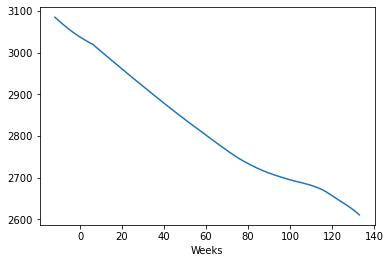

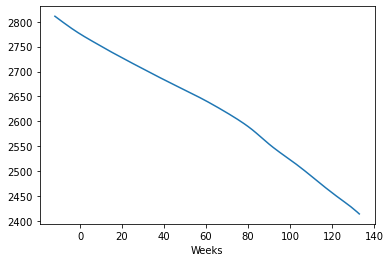

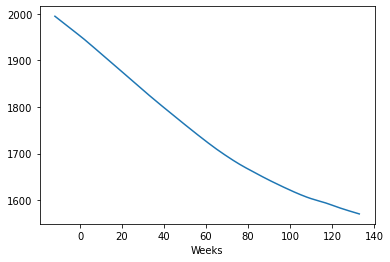

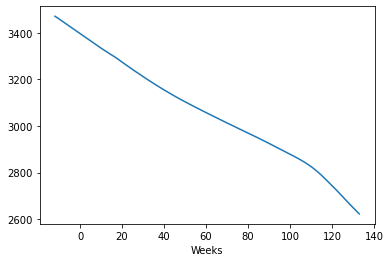

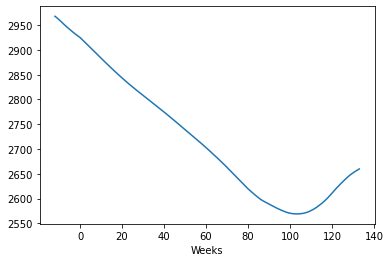

In [66]:
for ID in sub.Patient.unique():
    sub_ID=sub[sub.Patient==ID]
    sns.lineplot(sub_ID.Weeks,avg_test_pred_exp[sub.Patient==ID])
    #sns.lineplot(sub_ID.Weeks,t_preds[sub.Patient==ID])
    plt.show()

In [67]:
sub.head(50)

,Patient_Week,Patient,Weeks,Age,Sex,SmokingStatus,STD_FVC,Age_Week,Sex_Label,mode_l1,...,Area_r1,Area_r2,Ex-smoker,Never smoked,Base_Percent,Base_FVC,Base_Weeks,Area,FVC,Confidence
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3084.860137,290.785877
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3080.274618,290.336968
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3075.786167,289.895826
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3071.395540,289.462107
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3067.102463,289.035594
5,ID00419637202311204720264_-7,ID00419637202311204720264,-7,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3062.911044,288.617151
6,ID00419637202311204720264_-6,ID00419637202311204720264,-6,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3058.839967,288.210250
7,ID00419637202311204720264_-5,ID00419637202311204720264,-5,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3054.904113,287.817245
8,ID00419637202311204720264_-4,ID00419637202311204720264,-4,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3051.098697,287.437789
9,ID00419637202311204720264_-3,ID00419637202311204720264,-3,73,Male,Ex-smoker,4302.8,73.12,79,-1024.0,...,87545.149321,185951.767639,1,0,70.186855,3020,6,535551.642058,3047.423216,287.072875


In [68]:
sub=sub[['Patient_Week','FVC','Confidence']]
sub.to_csv('submission.csv',index=False)
sub.head(50)

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3084.860137,290.785877
1,ID00419637202311204720264_-11,3080.274618,290.336968
2,ID00419637202311204720264_-10,3075.786167,289.895826
3,ID00419637202311204720264_-9,3071.395540,289.462107
4,ID00419637202311204720264_-8,3067.102463,289.035594
5,ID00419637202311204720264_-7,3062.911044,288.617151
6,ID00419637202311204720264_-6,3058.839967,288.210250
7,ID00419637202311204720264_-5,3054.904113,287.817245
8,ID00419637202311204720264_-4,3051.098697,287.437789
9,ID00419637202311204720264_-3,3047.423216,287.072875
